In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning, 
                        message="use_inf_as_na option is deprecated")

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest, RandomForestRegressor

from scipy import stats

import xgboost as xgb

import pingouin as pg

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from deap import base, creator, tools, algorithms

<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
"> I - Context and summary</div>

### Business Context

This case study focuses on predicting rental prices for apartments listed on Airbnb in London. The primary business objectives are:

1. **Investment Analysis**: Determine potential revenue expectations for property investments in London's Airbnb market
2. **Pricing Strategy**: Identify optimal pricing for apartments based on their features and locations
3. **Market Insights**: Understand the relationship between apartment characteristics and rental value

### Dataset Overview

The dataset contains **51,646 observations** with **65 variables** describing various aspects of Airbnb listings in London. After initial data cleaning, we retained properties that accommodate fewer than 8 people and removed observations with missing critical variables.

### Variable Categories

- **Quantitative Variables (10)**: Numerical features prefixed with `n_` including accommodation capacity, number of beds, bathrooms, review scores, etc.
- **Qualitative Variables (5)**: Categorical features prefixed with `f_` including property type, room type, cancellation policy, etc.
- **Binary/Dummy Variables (49)**: Amenity indicators and borough locations prefixed with `d_`

### Methodology Overview

Our analytical approach follows a structured pipeline:
1. Data cleaning and column-wise validation
2. Exploratory data analysis to understand distributions and relationships
3. Data preparation for modeling (encoding, multicollinearity checks)
4. Model development using various regression techniques
5. Model improvement through regularization and optimization
6. Comparative performance evaluation
7. Final model selection and conclusions

In [15]:
data = pd.read_csv("airbnb_london_homework.csv")

In [ ]:
print(f"Dimensions: {data.shape}")
print(data.info())
print(data.describe())

quantitative = [col for col in data.columns if col.startswith('n_')]
qualitative = [col for col in data.columns if col.startswith('f_')]
dummies = [col for col in data.columns if col.startswith('d_')]
print(f"Quantitatives: {len(quantitative)} variables")
print(f"Qualitatives: {len(qualitative)} variables")
print(f"Dummies: {len(dummies)} variables")

Dimensions: (51646, 65)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51646 entries, 0 to 51645
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   f_property_type            51646 non-null  object 
 1   f_room_type                51646 non-null  object 
 2   f_cancellation_policy      51646 non-null  object 
 3   f_bed_type                 51646 non-null  object 
 4   f_neighbourhood_cleansed   51646 non-null  object 
 5   usd_price_day              51646 non-null  int64  
 6   n_accommodates             51646 non-null  int64  
 7   n_bathrooms                51646 non-null  float64
 8   n_review_scores_rating     51646 non-null  int64  
 9   n_number_of_reviews        51646 non-null  int64  
 10  n_guests_included          51646 non-null  int64  
 11  n_reviews_per_month        51646 non-null  float64
 12  n_extra_people             51646 non-null  int64  
 13  n_minimum_nights      

<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
"> II - Cleaning individual columns</div>

### **Data Quality Assessment Strategy**

Before proceeding with analysis, we conduct comprehensive data cleaning to ensure:

- **Data Integrity**: Verify no missing values in critical columns
- **Value Ranges**: Check for unrealistic or outlier values
- **Consistency**: Ensure categorical variables have appropriate levels
- **Distribution Analysis**: Understand the spread and central tendencies of numerical variables

<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu'un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  1/ Numerical columns
</div>

### Numerical Variables Analysis

We systematically examine all numerical variables (`n_` prefix) to:

- **Identify Data Ranges**: Understand minimum and maximum values
- **Assess Central Tendency**: Calculate mean and median values
- **Evaluate Spread**: Compute standard deviation and variance
- **Detect Outliers**: Identify extreme values that may skew analysis

This comprehensive profiling helps us understand the distribution characteristics and identify potential data quality issues that need addressing before modeling.

In [ ]:
n_columns = data[[col for col in data.columns if col.startswith('n_')]]

for col in n_columns :
    tab = data[col]
    print(col)
    print(f'Min : {min(tab.unique())} / Max : {max(tab.unique())} / Moy : {np.mean(tab)} / Mediane : {np.median(tab)} / Ecart-type : {np.sqrt(np.var(tab))} / nombre na : {tab.isna().sum()}')

n_accommodates
Min : 1 / Max : 16 / Moy : 3.057177709793595 / Médiane : 2.0 / Ecart-type : 1.888490742844852 / nombre na : 0
n_bathrooms
Min : 0.0 / Max : 8.0 / Moy : 1.2607075088099755 / Médiane : 1.0 / Ecart-type : 0.5270893067341791 / nombre na : 0
n_review_scores_rating
Min : 20 / Max : 100 / Moy : 92.43962746388878 / Médiane : 94.0 / Ecart-type : 8.438270901108579 / nombre na : 0
n_number_of_reviews
Min : 0 / Max : 396 / Moy : 12.35032722766526 / Médiane : 3.0 / Ecart-type : 25.860224303953835 / nombre na : 0
n_guests_included
Min : 1 / Max : 16 / Moy : 1.4157727607171902 / Médiane : 1.0 / Ecart-type : 1.044873888784467 / nombre na : 0
n_reviews_per_month
Min : 0.0099999998 / Max : 15.0 / Moy : 1.1389704851480194 / Médiane : 0.76999998 / Ecart-type : 1.2365401646138103 / nombre na : 0
n_extra_people
Min : 0 / Max : 240 / Moy : 6.665550091004143 / Médiane : 0.0 / Ecart-type : 12.691232512883973 / nombre na : 0
n_minimum_nights
Min : 1 / Max : 5000 / Moy : 3.3102660419006313 / Média

## **1. Outlier Analysis Methodology**

#### **Initial Observations and Methodological Refinement**

Our initial outlier detection revealed an important insight: traditional outlier detection methods (IQR with 1.5× threshold) may not be appropriate for this dataset due to the inherent characteristics of rental market data.

**Key Realizations:**
1. **Initial IQR analysis** indicated a substantial number of potential outliers across most quantitative variables
2. **Distribution analysis** revealed that many variables exhibit natural heavy-tailed distributions characteristic of real-world economic data
3. **Domain context** suggests that extreme values often represent genuine market variations rather than data errors

**Methodological Approach:**
We employ multiple complementary techniques to characterize each variable's distribution:
- **Descriptive Statistics**: Central tendency and dispersion measures
- **Visual Analysis**: Histograms and density plots
- **Normality Testing**: Statistical tests for distribution shape
- **Skewness and Kurtosis**: Quantification of distribution asymmetry and tail behavior

Distribution Analysis for n_accommodates:
Mean: 3.06
Std: 1.89
Skewness: 1.69
Kurtosis: 4.17


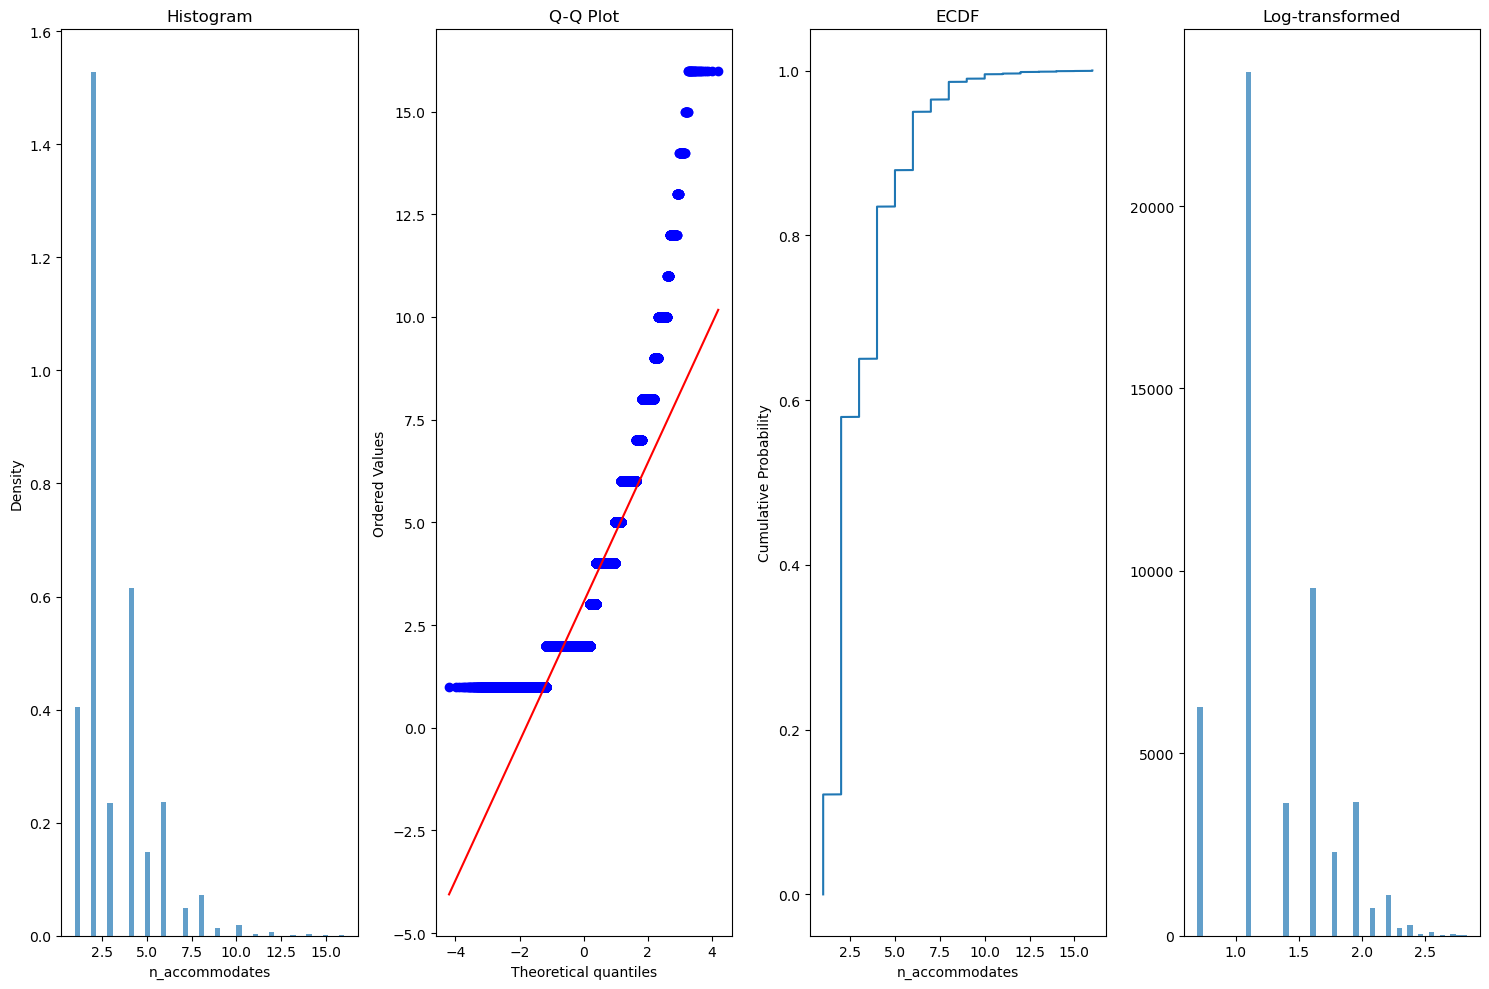

Distribution Analysis for n_bathrooms:
Mean: 1.26
Std: 0.53
Skewness: 2.55
Kurtosis: 11.44


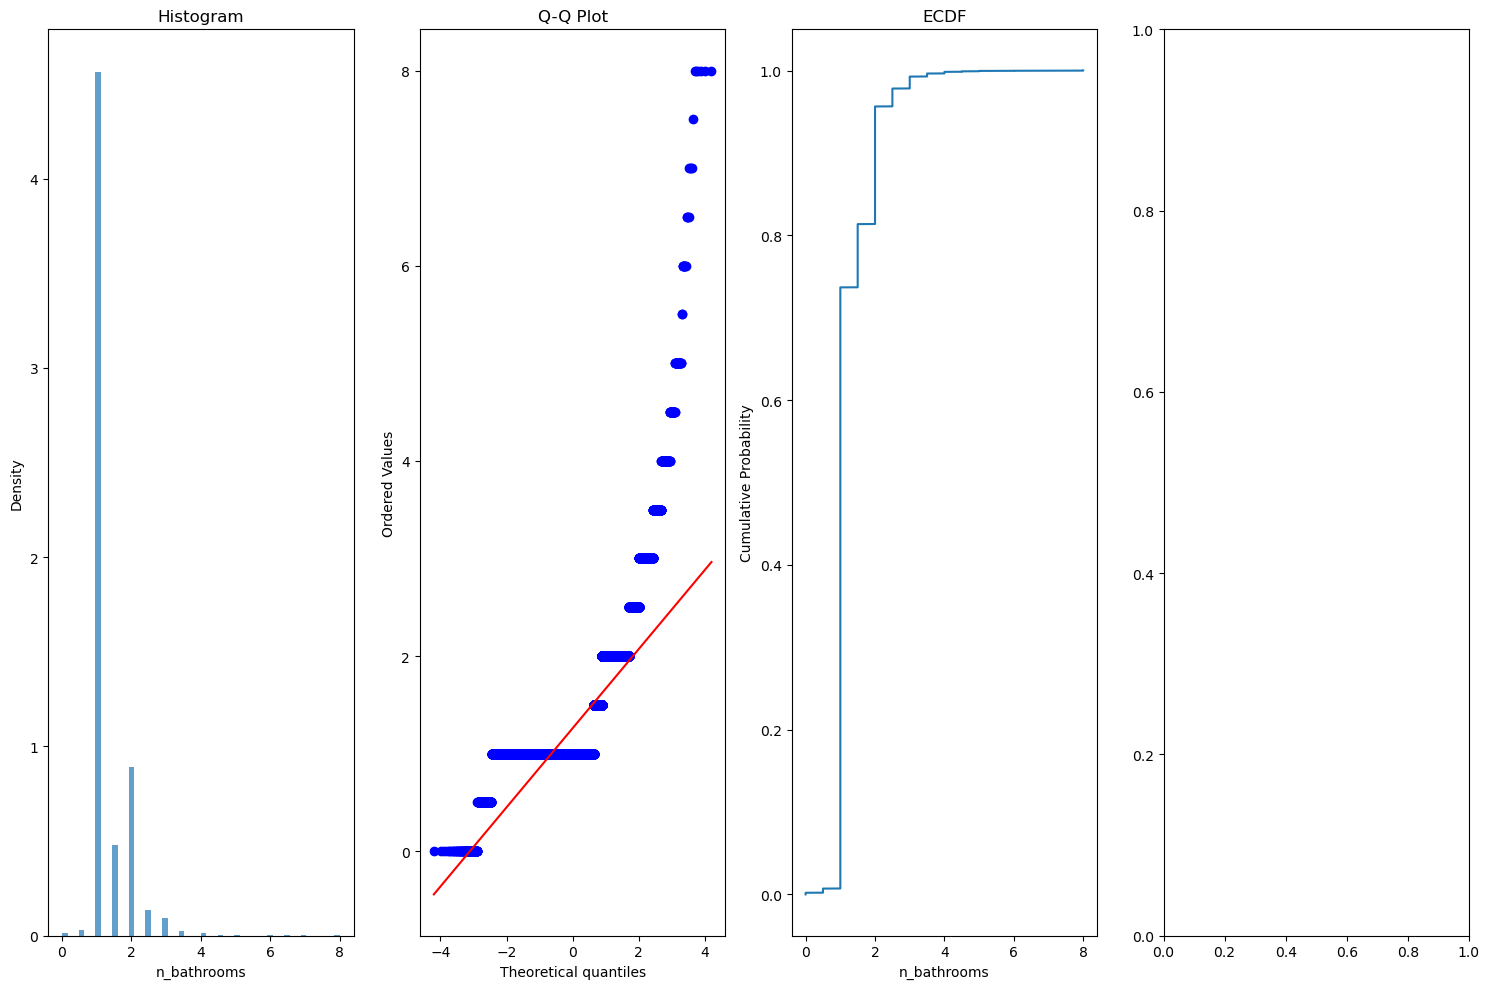

Distribution Analysis for n_review_scores_rating:
Mean: 92.44
Std: 8.44
Skewness: -3.37
Kurtosis: 18.24


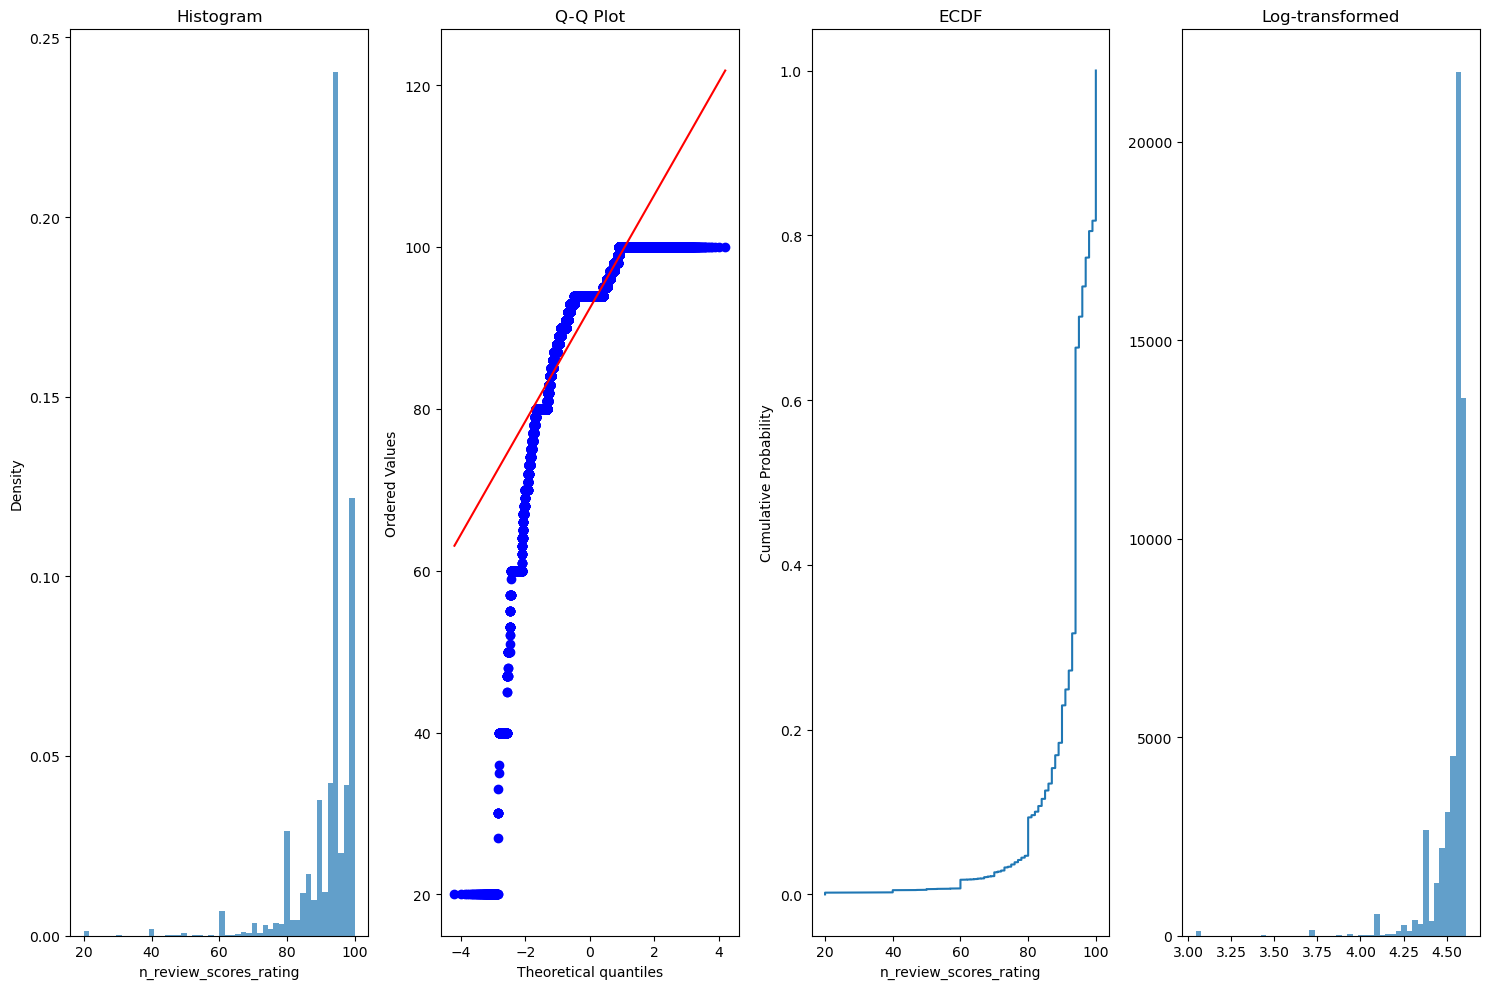

Distribution Analysis for n_number_of_reviews:
Mean: 12.35
Std: 25.86
Skewness: 4.55
Kurtosis: 30.40


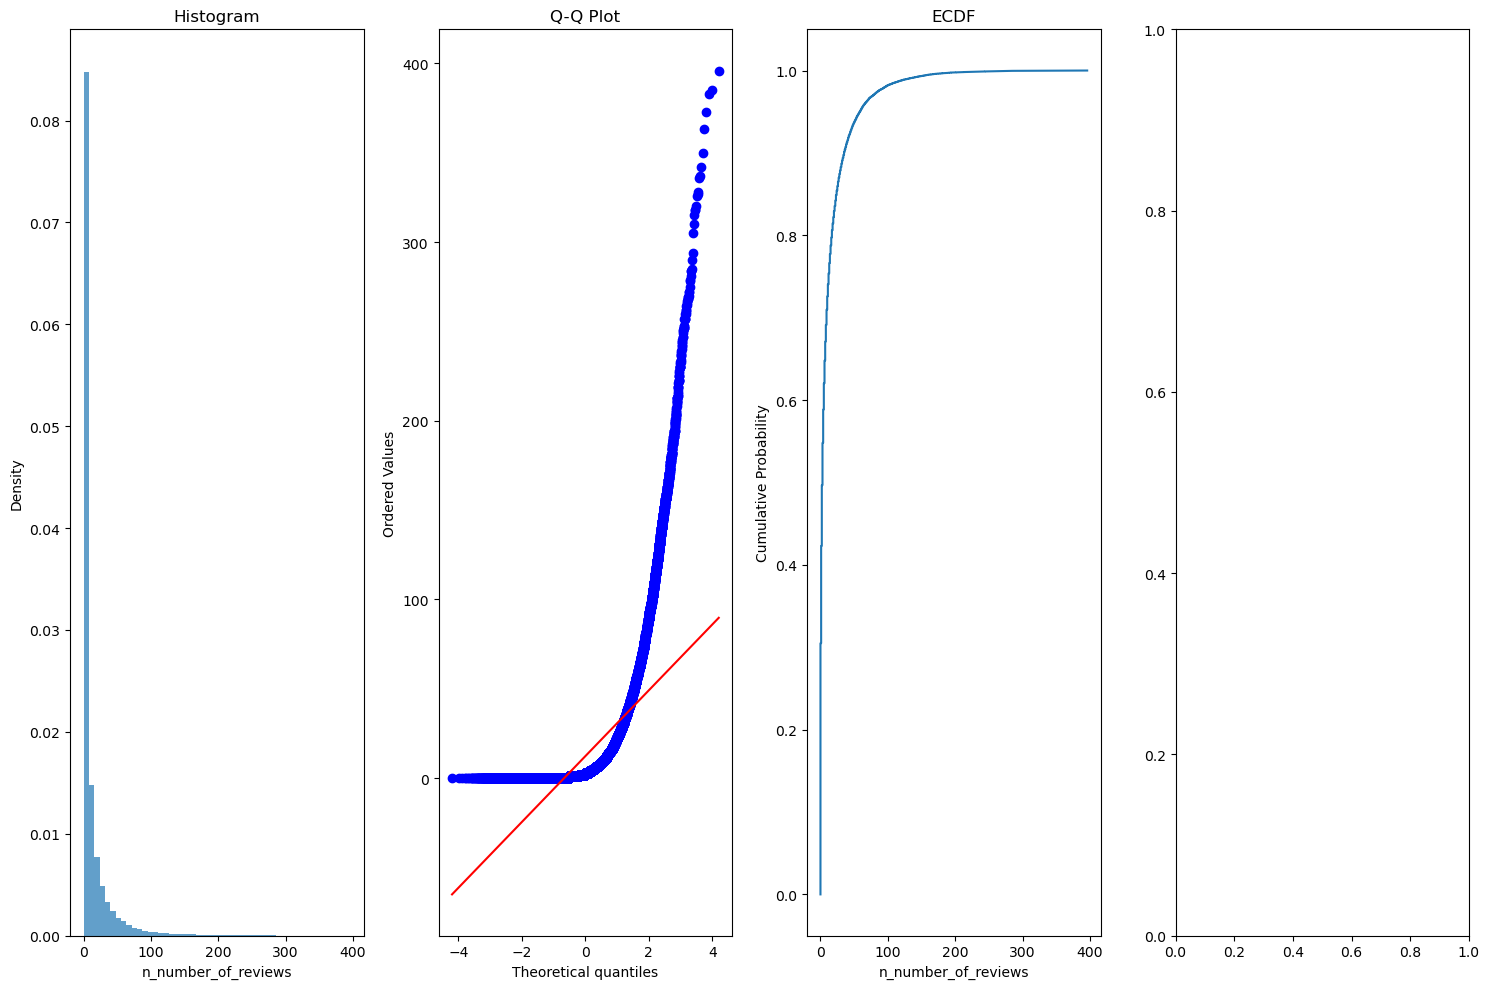

Distribution Analysis for n_guests_included:
Mean: 1.42
Std: 1.04
Skewness: 3.76
Kurtosis: 20.61


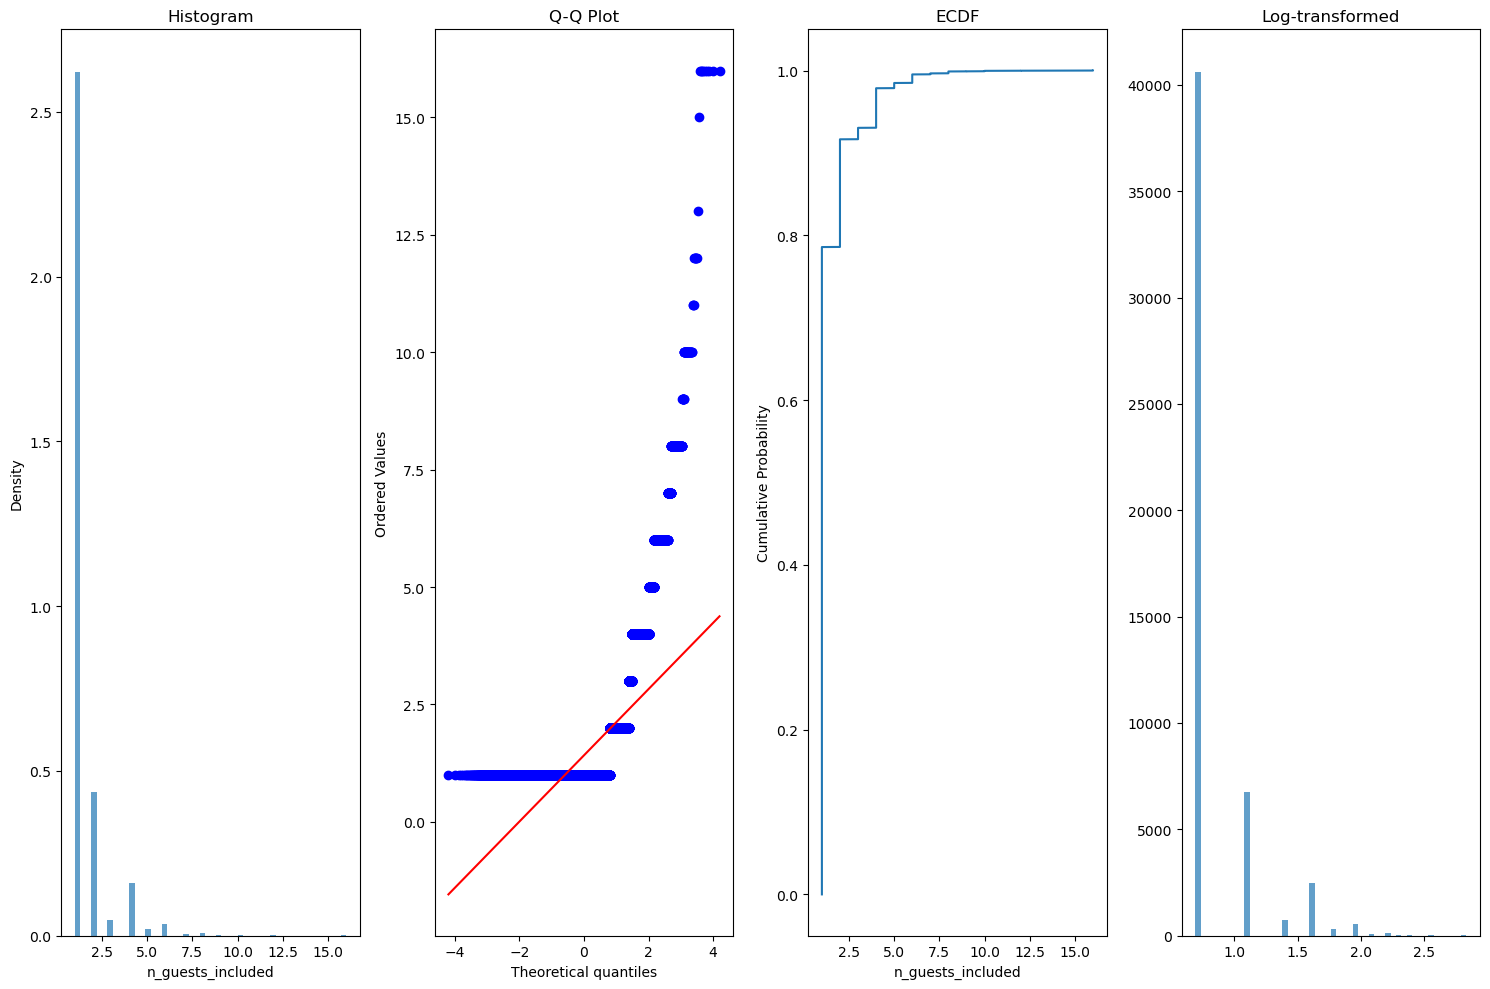

Distribution Analysis for n_reviews_per_month:
Mean: 1.14
Std: 1.24
Skewness: 2.68
Kurtosis: 9.44


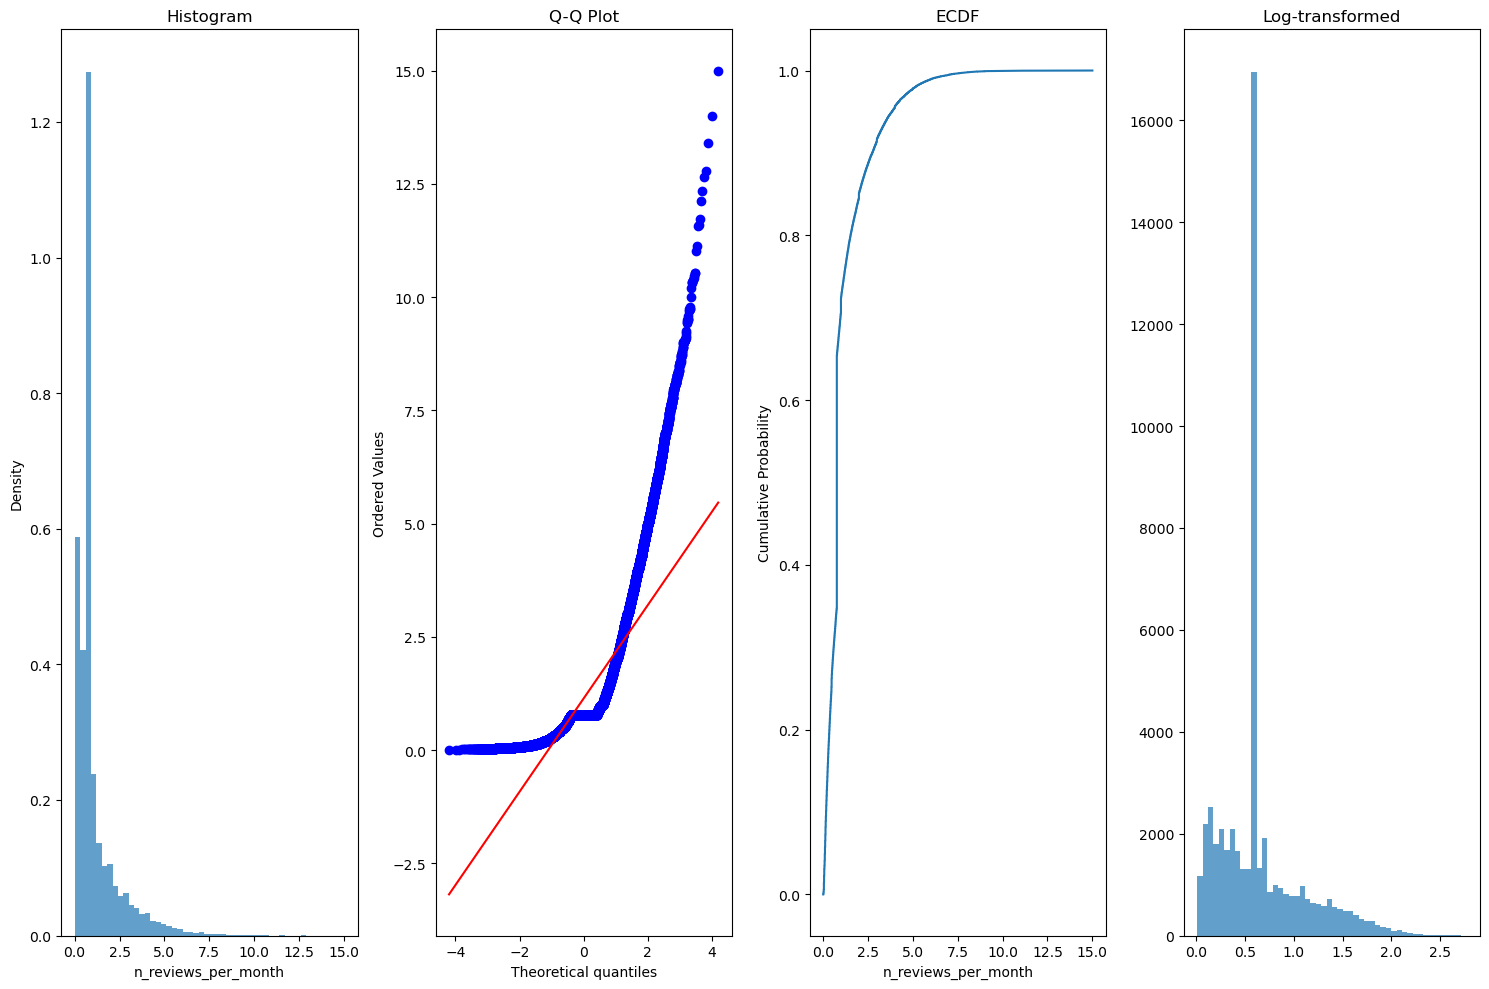

Distribution Analysis for n_extra_people:
Mean: 6.67
Std: 12.69
Skewness: 4.98
Kurtosis: 51.83


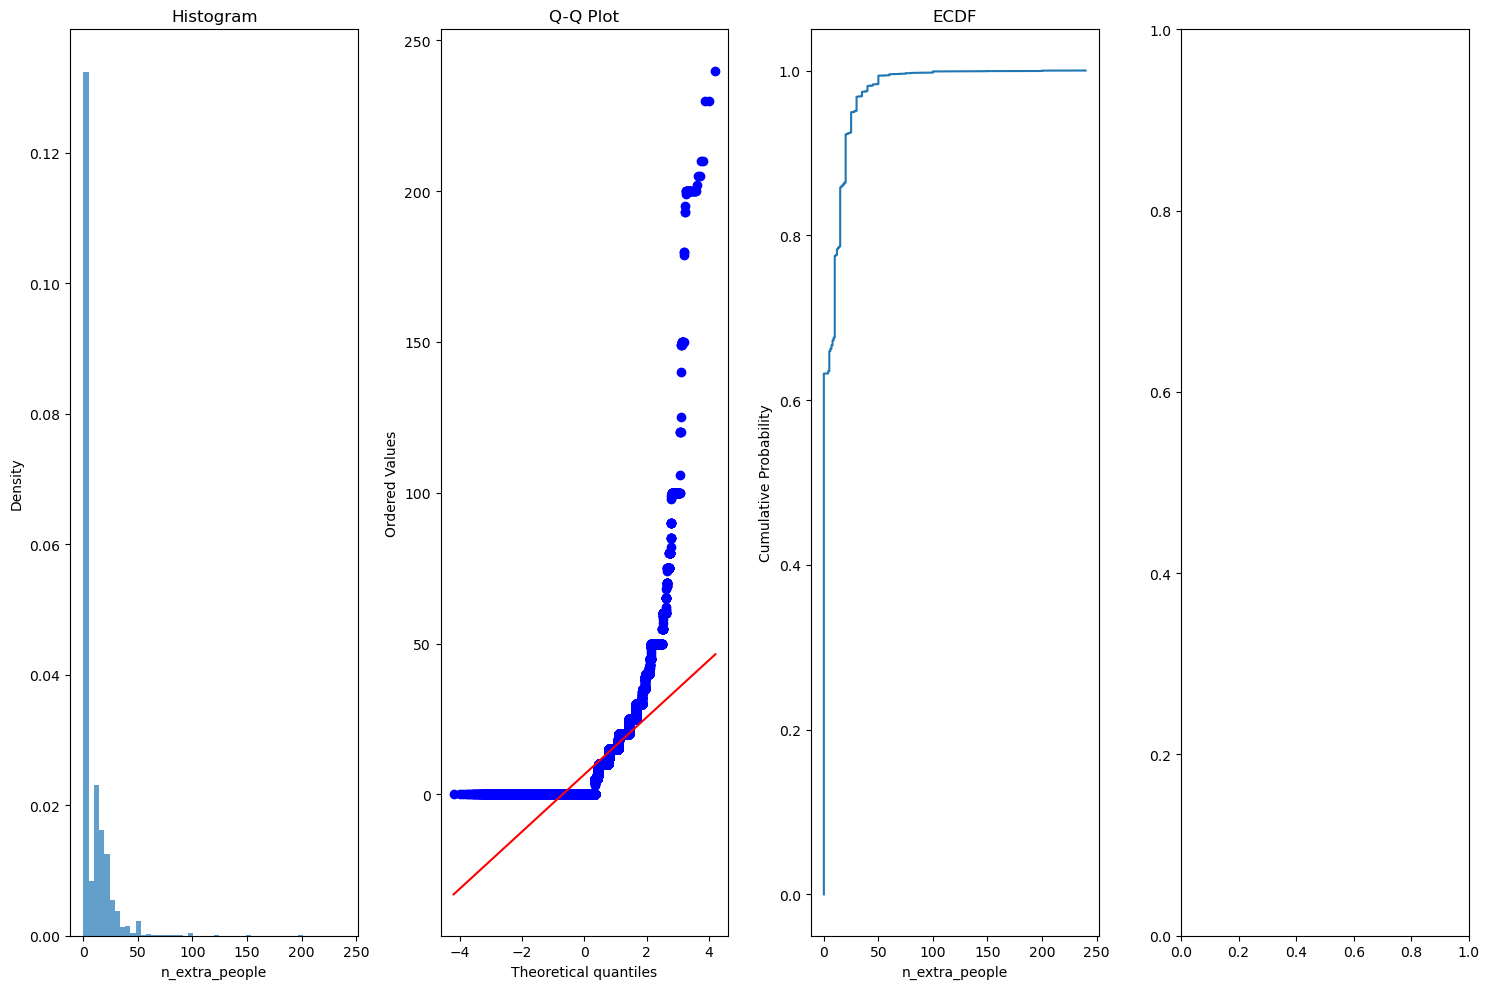

Distribution Analysis for n_minimum_nights:
Mean: 3.31
Std: 29.08
Skewness: 145.34
Kurtosis: 23060.35


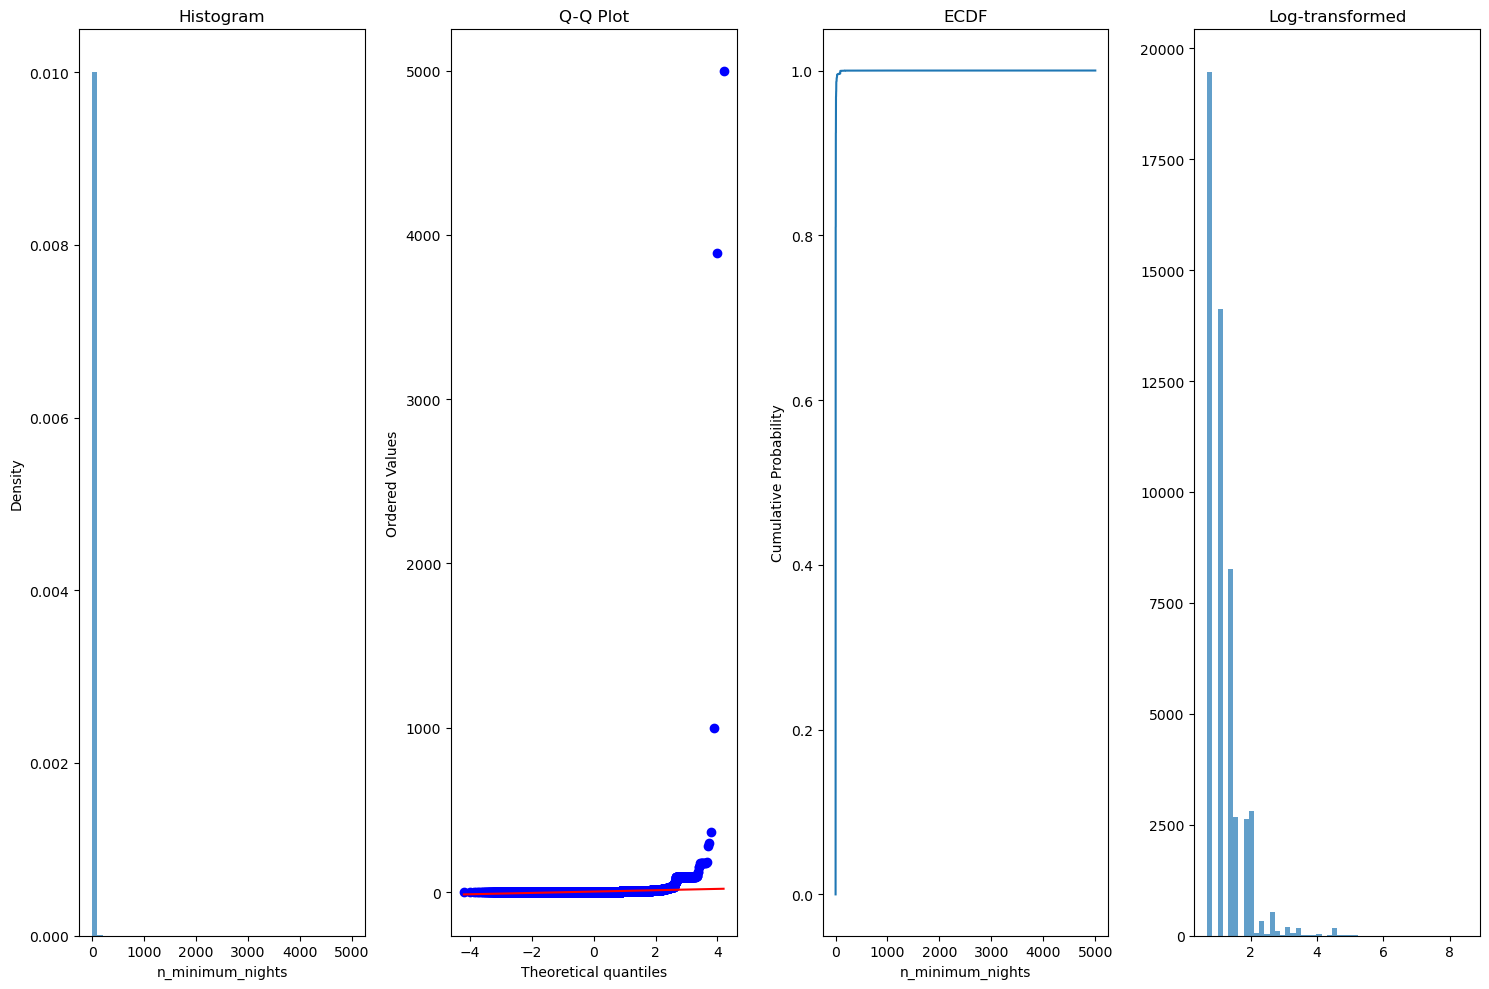

Distribution Analysis for n_beds:
Mean: 1.71
Std: 1.17
Skewness: 2.71
Kurtosis: 12.48


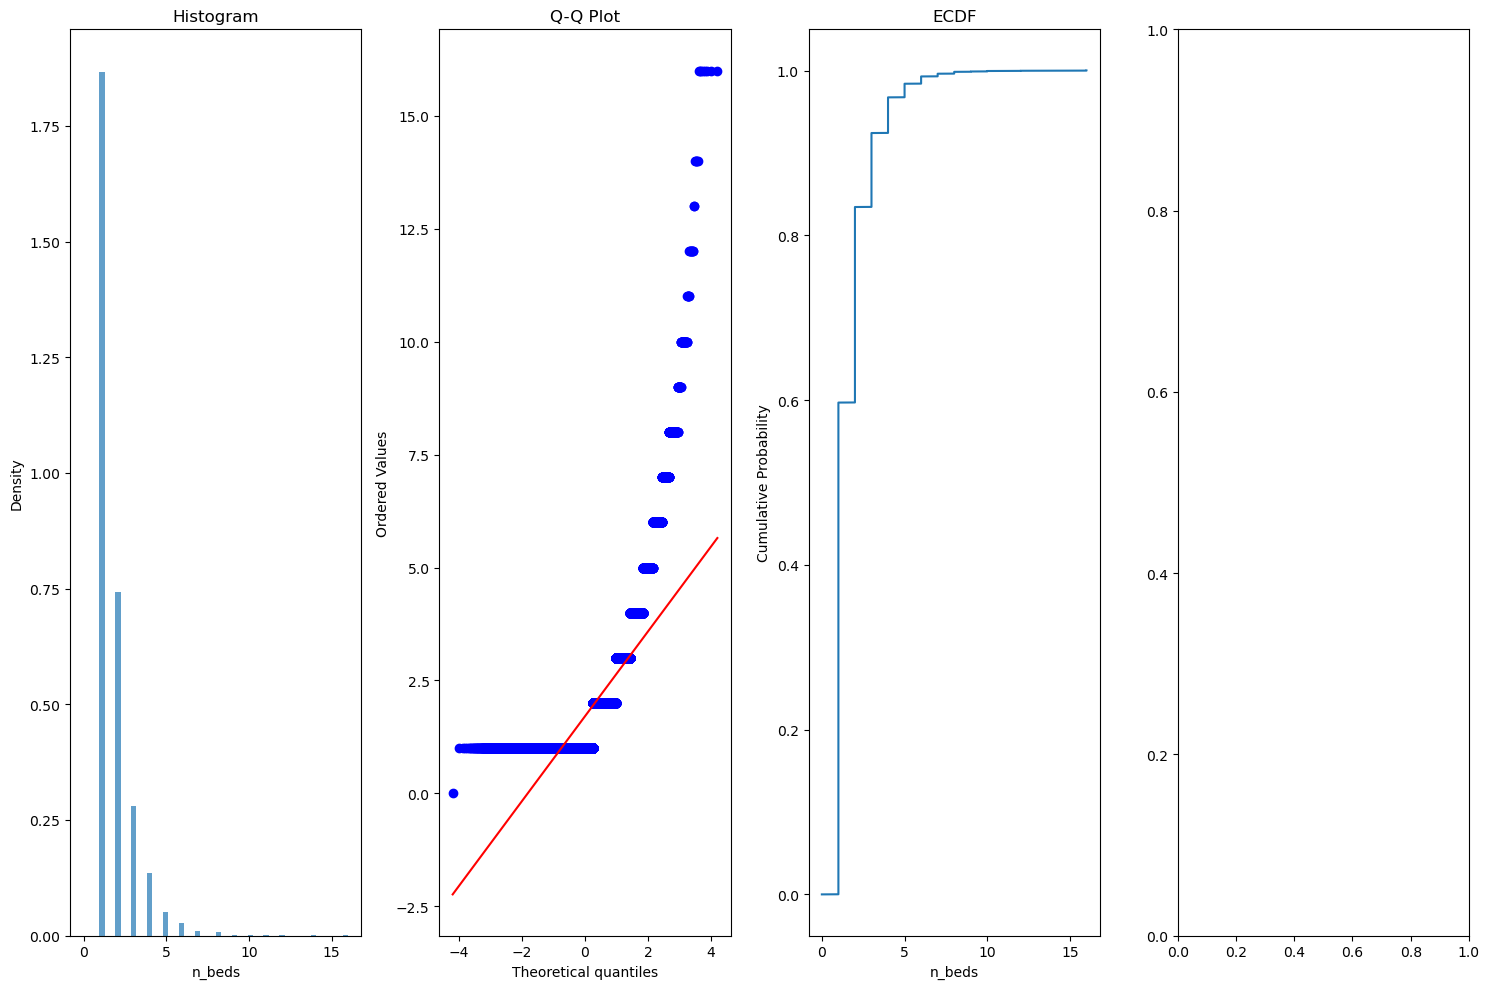

Distribution Analysis for n_days_since:
Mean: 418.13
Std: 344.65
Skewness: 2.03
Kurtosis: 4.82


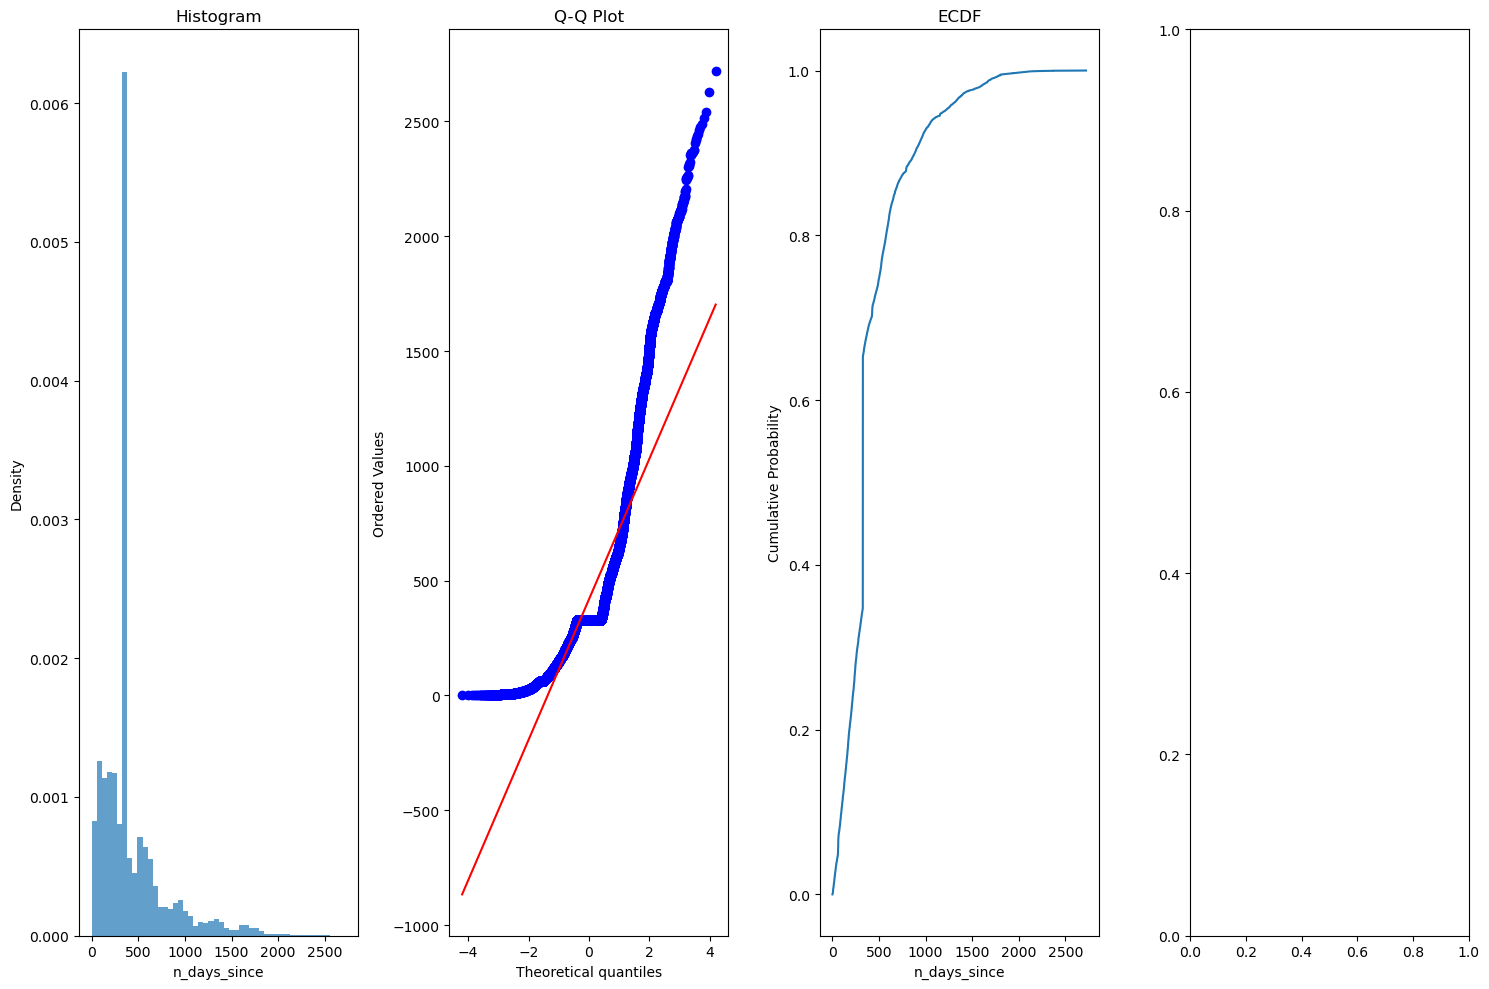

In [18]:
def analyze_distribution(df, column):
    """Comprehensive distribution analysis"""
    data = df[column]

        # Print statistics
    print(f"Distribution Analysis for {column}:")
    print(f"Mean: {data.mean():.2f}")
    print(f"Std: {data.std():.2f}")
    print(f"Skewness: {data.skew():.2f}")
    print(f"Kurtosis: {data.kurtosis():.2f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    
    # Histogram with density
    axes[0].hist(data, bins=50, alpha=0.7, density=True)
    axes[0].set_title('Histogram')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Density')
    
    
    # Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot')
    
    # ECDF plot
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    axes[2].plot(sorted_data, yvals)
    axes[2].set_title('ECDF')
    axes[2].set_xlabel(column)
    axes[2].set_ylabel('Cumulative Probability')
    
    # Log transformation visualization
    if data.min() > 0:
        log_data = np.log1p(data)
        axes[3].hist(log_data, bins=50, alpha=0.7)
        axes[3].set_title('Log-transformed')
    
    plt.tight_layout()
    plt.show()

# Analyze your variable
for col in n_columns.columns: 
    analyze_distribution(n_columns, col)

#### **Key Findings & Implications**

**Distribution Characteristics:**
- Most quantitative variables exhibit **significant skewness and heavy-tailed distributions**
- Distribution patterns are characteristic of **real-world economic data**
- Traditional symmetric distribution assumptions are **invalid for this dataset**

**Outlier Reinterpretation:**
- Many apparent "outliers" represent **legitimate extreme values** in naturally skewed distributions
- Requires **distribution-sensitive preprocessing** rather than conventional outlier removal
- **Contextual understanding** supersedes automatic outlier elimination

### **Robust Outlier Detection Methodology**

**Technical Approach:**

- **Median Absolute Deviation (MAD)**: Robust alternative to standard deviation
- **Quantile-Based Thresholds**: Distribution-adaptive bounds using extreme percentiles
- **Modified Z-scores**: Outlier detection resistant to influence of extreme values
- **Domain-Specific Validation**: Business logic checks alongside statistical methods

In [19]:
def robust_outlier_detection(df, column, method):
    """
    More robust outlier detection for heavy-tailed distributions
    """
    data = df[column]
    
    if method == 'adjusted_boxplot':
        # Adjusted boxplot for skewed data
        Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
        IQR = Q3 - Q1
        median = data.median()
        
        # Calculate medcouple (measure of skewness)
        try:
            from scipy.stats import mstats
            mc = mstats.medcouple(data.values)
        except:
            # Fallback: use simple skewness measure
            mc = data.skew() / 10  # rough approximation
            
        if mc >= 0:
            # Right-skewed
            lower_bound = Q1 - 1.5 * np.exp(-4 * mc) * IQR
            upper_bound = Q3 + 1.5 * np.exp(3 * mc) * IQR
        else:
            # Left-skewed
            lower_bound = Q1 - 1.5 * np.exp(-3 * mc) * IQR
            upper_bound = Q3 + 1.5 * np.exp(4 * mc) * IQR
            
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        
    elif method == 'percentile':
        # Use percentiles instead of IQR
        lower_bound = data.quantile(0.01)  # 1st percentile
        upper_bound = data.quantile(0.99)  # 99th percentile
        outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    elif method == 'log_transform':
        # Apply IQR on log-transformed data
        if data.min() > 0:
            log_data = np.log1p(data)
            Q1_log, Q3_log = log_data.quantile(0.25), log_data.quantile(0.75)
            IQR_log = Q3_log - Q1_log
            lower_log = Q1_log - 1.5 * IQR_log
            upper_log = Q3_log + 1.5 * IQR_log
            
            # Convert back to original scale
            lower_bound = np.expm1(lower_log)
            upper_bound = np.expm1(upper_log)
            outliers = data[(data < lower_bound) | (data > upper_bound)]
        else:
            print("Cannot apply log transform to non-positive values")
            return None
    
    return {
        'outliers': outliers,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'count': len(outliers),
        'percentage': len(outliers) / len(data) * 100
    }

# Test different methods
for col in n_columns.columns:
    methods = ['adjusted_boxplot', 'percentile', 'log_transform']
    for method in methods:
        if method == 'log_transform' and n_columns[col].min() <= 0:
            continue
        result = robust_outlier_detection(n_columns, col , method)
        if result:
            print(f"\n{method.upper()} METHOD:{col}")
            print(f"Outliers: {result['count']:,} ({result['percentage']:.1f}%)")
            print(f"Bounds: [{result['lower_bound']:.2f}, {result['upper_bound']:.2f}]")


ADJUSTED_BOXPLOT METHOD:n_accommodates
Outliers: 713 (1.4%)
Bounds: [0.47, 8.98]

PERCENTILE METHOD:n_accommodates
Outliers: 512 (1.0%)
Bounds: [1.00, 9.00]

LOG_TRANSFORM METHOD:n_accommodates
Outliers: 512 (1.0%)
Bounds: [0.39, 9.76]

ADJUSTED_BOXPLOT METHOD:n_bathrooms
Outliers: 744 (1.4%)
Bounds: [0.73, 3.11]

PERCENTILE METHOD:n_bathrooms
Outliers: 744 (1.4%)
Bounds: [1.00, 3.00]

ADJUSTED_BOXPLOT METHOD:n_review_scores_rating
Outliers: 11,496 (22.3%)
Bounds: [71.36, 98.95]

PERCENTILE METHOD:n_review_scores_rating
Outliers: 368 (0.7%)
Bounds: [60.00, 100.00]

LOG_TRANSFORM METHOD:n_review_scores_rating
Outliers: 5,985 (11.6%)
Bounds: [84.97, 105.01]

ADJUSTED_BOXPLOT METHOD:n_number_of_reviews
Outliers: 1,403 (2.7%)
Bounds: [-2.91, 82.56]

PERCENTILE METHOD:n_number_of_reviews
Outliers: 515 (1.0%)
Bounds: [0.00, 130.00]

ADJUSTED_BOXPLOT METHOD:n_guests_included
Outliers: 11,066 (21.4%)
Bounds: [1.00, 1.00]

PERCENTILE METHOD:n_guests_included
Outliers: 244 (0.5%)
Bounds: [1.00,

#### **Critical Findings**

- **Minimal True Outliers**: Only approximately 1% of observations represent genuine statistical outliers
- **Premium Market Reality**: Most extreme values are legitimate representations of premium market segments
- **Natural Distribution Characteristics**: The rental market naturally exhibits heavy-tailed distributions with meaningful extremes

## **2. Correlation**

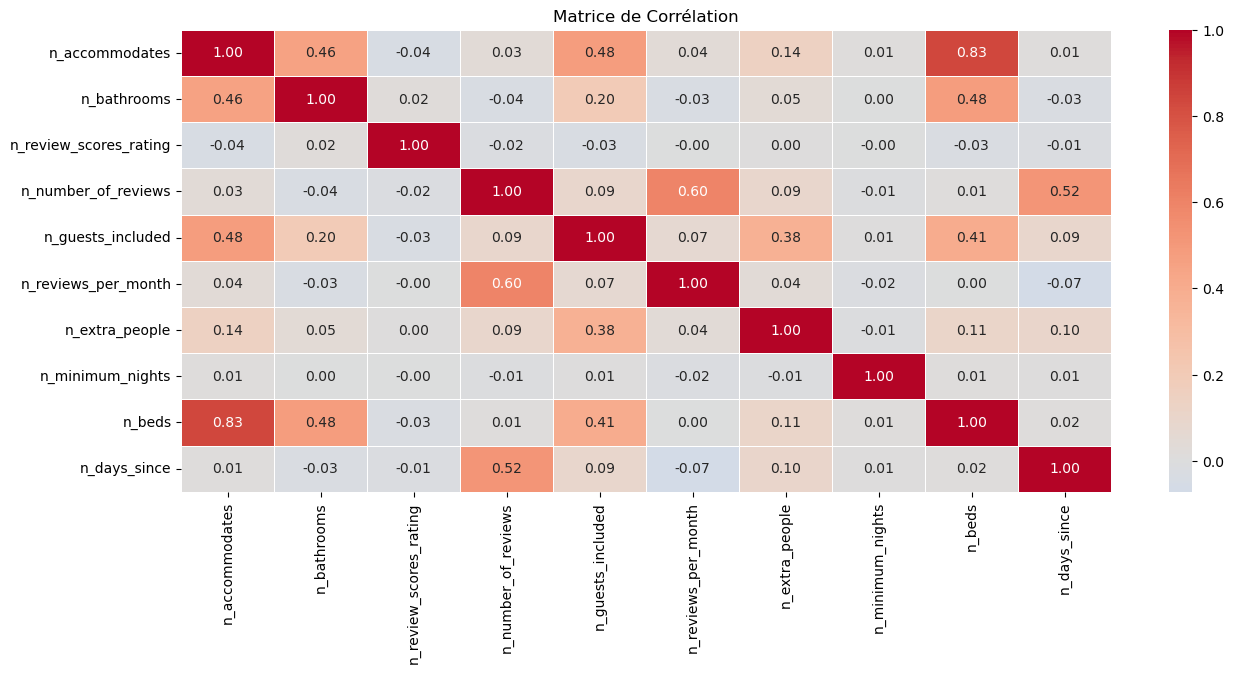

Variables supprimées : ['n_beds']
Nombre de variables restantes : 64


In [ ]:
correlation_matrix = n_columns.corr()

plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=False, linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


corr_matrix = n_columns.corr().abs()  

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  
to_drop = []

for col in upper.columns:
    correlated_vars = upper.index[upper[col] > 0.8].tolist()
    for var in correlated_vars:
        corr_with_price_col = n_columns[col].corr(data['usd_price_day'])
        corr_with_price_var = n_columns[var].corr(data['usd_price_day'])


        if abs(corr_with_price_col) < abs(corr_with_price_var):
            to_drop.append(col)
        else:
            to_drop.append(var)

to_drop = list(set(to_drop))

data = data.drop(columns=to_drop)

print(f"Variables to drop : {to_drop}")
print(f"Number of variables : {data.shape[1]}")


<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  2/ Dummy Variables Analysis
</div>

**Objective :**

In this section, we conduct a comprehensive analysis of the dummy variables (binary features) in our dataset. These variables represent various amenities and location indicators that could significantly influence rental prices. Our goal is to understand their distribution, relationships, and impact on our target variable to prepare for effective modeling.


### **1. Frequency Analysis of Binary Variables**

**Purpose:**
Examine the distribution and prevalence of each amenity/location feature

**Rationale:**
Identify which amenities are common vs. rare, and detect potential data quality issues (e.g., features with near-zero variance)

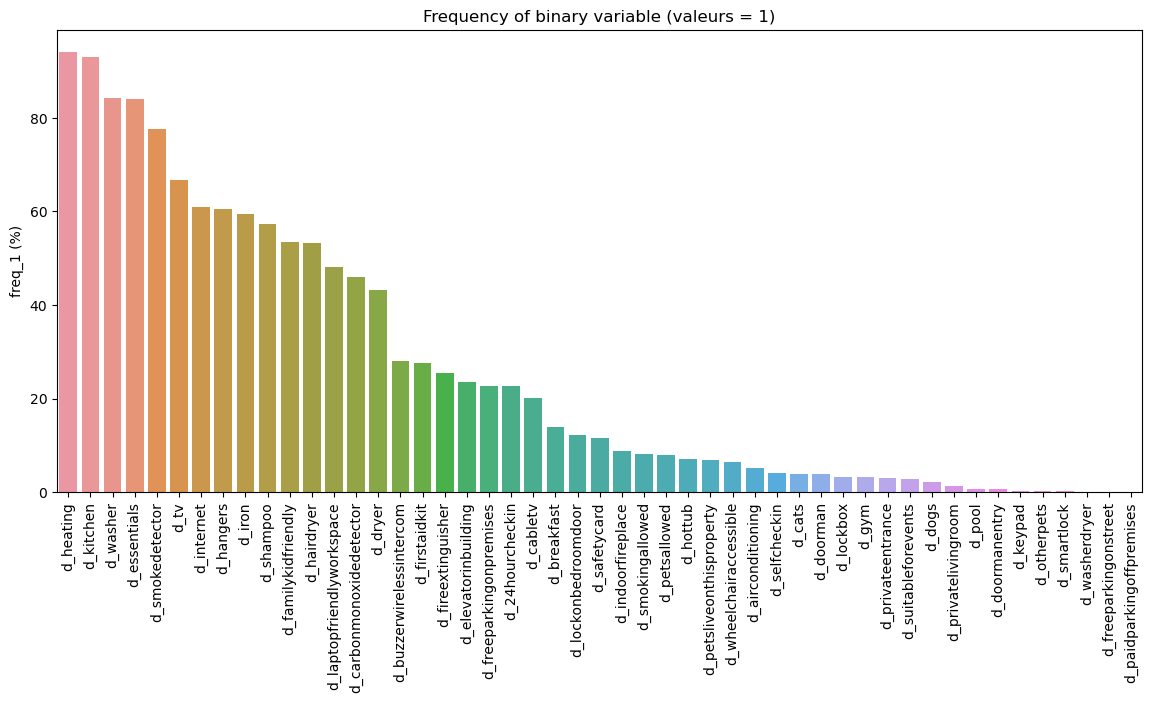

d_selfcheckin : 4.182318088525733
d_cats : 3.8454091313944936
d_doorman : 3.7989389304108743
d_lockbox : 3.1832087673779186
d_gym : 3.146419858265887
d_privateentrance : 3.0728420400418233
d_suitableforevents : 2.7707857336482977
d_dogs : 2.064051427022422
d_privatelivingroom : 1.3108469194129264
d_pool : 0.7551407659838129
d_doormanentry : 0.5770049955466057
d_keypad : 0.28850249777330284
d_otherpets : 0.2555861054099059
d_smartlock : 0.18588080393447703
d_washerdryer : 0.07938659334701623
d_freeparkingonstreet : 0.06776904310111141
d_paidparkingoffpremises : 0.04453394260930178


In [ ]:
d_columns = data[[col for col in data.columns if col.startswith('d_')]]

desc = pd.DataFrame({
    'nb_1': d_columns.sum(),
    'freq_1 (%)': d_columns.mean()*100
}).sort_values('freq_1 (%)', ascending=False)
        
plt.figure(figsize=(14,6))
sns.barplot(x=desc.index, y=desc['freq_1 (%)'])
plt.xticks(rotation=90)
plt.title("Frequency of binary variable (value = 1)")
plt.show()

for i,j in zip(desc.index, desc['freq_1 (%)']): 
    if j<5 or j>95 : 
        print(f"{i} : {j}")
        d_columns = d_columns.drop(columns=i)
        data = data.drop(columns=i)

### **2. Correlation Analysis**

**Purpose:**
Assess relationships between dummy variables and identify potential multicollinearity

**Rationale:**
High correlation between features can cause instability in regression models and complicate interpretation

<Axes: >

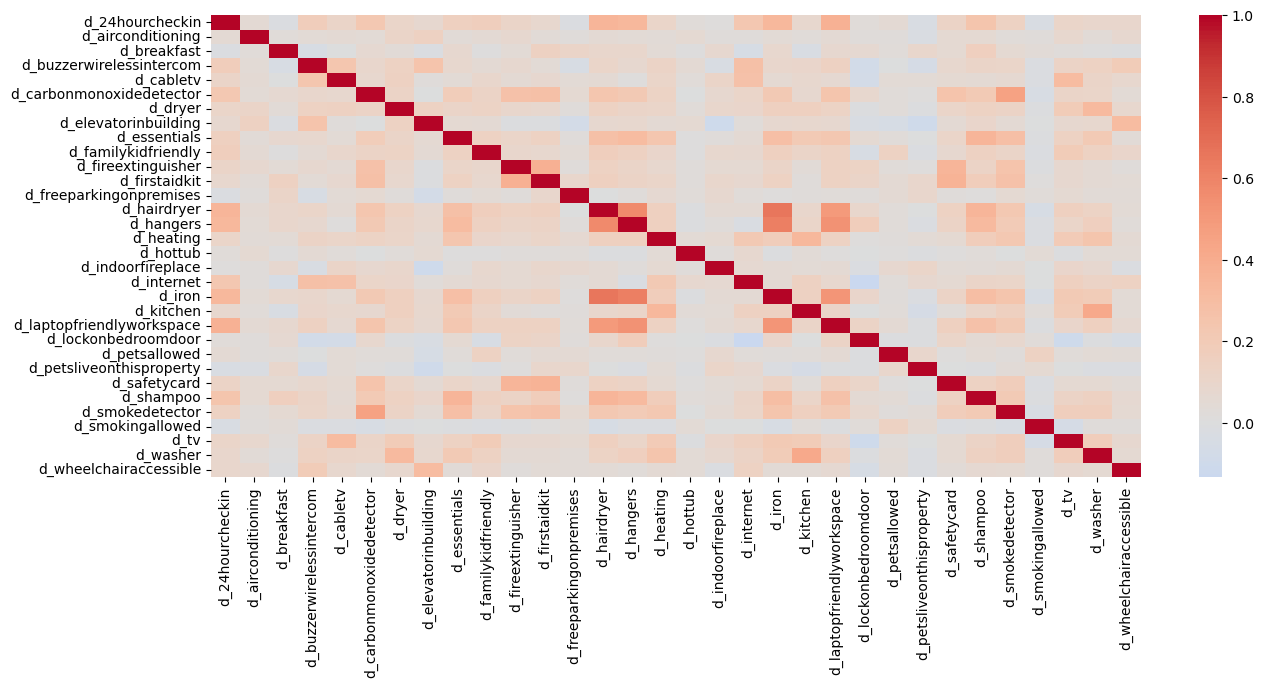

In [22]:
corr = d_columns.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(corr, cmap="coolwarm", center=0)

### **3. General Impact Assessment**

**Purpose:**
Evaluate how each dummy variable affects rental prices

**Rationale:**
Determine which amenities/locations have the strongest pricing influence to prioritize feature selection

In [ ]:
results = []

for col in d_columns.columns:
    mean_0 = data.loc[data[col] == 0, 'usd_price_day'].mean()
    mean_1 = data.loc[data[col] == 1, 'usd_price_day'].mean()
    diff = abs(mean_1 - mean_0)
    corr = data[col].corr(data['usd_price_day'])

    results.append([col, mean_0, mean_1, diff, abs(corr)])

impact_df = pd.DataFrame(results, columns=['Variable', 'Prix_0', 'Prix_1', 'Difference', 'Correlation'])
impact_df = impact_df.sort_values('Difference', ascending=False)

display(impact_df)

# plt.figure(figsize=(10,8))
# sns.barplot(data=impact_df, y='Variable', x='Différence', palette='coolwarm')
# plt.axvline(0, color='black', linestyle='--')
# plt.title("Impact moyen des variables binaires sur le prix (usd_price_day)")
# plt.xlabel("Différence de prix moyen (1 - 0)")
# plt.ylabel("")
# plt.show()

prix_moy_global = data['usd_price_day'].mean()

# Différences déjà calculées
impact_df['abs_diff_pct'] = (impact_df['Difference'].abs() / prix_moy_global) * 100

# Critères de suppression
vars_to_drop = impact_df.query("abs_diff_pct < 5")['Variable'].tolist()

print("Variables with low potential impact :", vars_to_drop)

#data = data.drop(columns = vars_to_drop)

,Variable,Prix_0,Prix_1,Différence,Corrélation
29,d_tv,63.815819,110.340514,46.524696,0.270778
1,d_airconditioning,92.578921,137.998856,45.419935,0.123207
9,d_familykidfriendly,71.259344,115.392954,44.133610,0.271994
17,d_indoorfireplace,91.515743,129.523591,38.007848,0.133488
6,d_dryer,80.654776,113.534404,32.879628,0.201300
4,d_cabletv,88.586033,119.934952,31.348919,0.155217
28,d_smokingallowed,97.377878,66.794537,30.583341,0.103407
22,d_lockonbedroomdoor,98.573437,68.175842,30.397595,0.122649
20,d_kitchen,66.726643,96.999084,30.272441,0.095342
24,d_petsliveonthisproperty,96.740165,70.152886,26.587279,0.083704


Variables à faible impact potentiel : ['d_firstaidkit']


### **4. Variable Grouping Strategy**

**Purpose:**
Organize related dummy variables into logical categories

**Rationale:**
Create meaningful feature groups (e.g., safety amenities, luxury features, pet policies) to enhance model interpretability and potentially create composite features

In [24]:
lasso = LassoCV(cv=5, random_state=42)

X = d_columns
y = data['usd_price_day']

lasso.fit(X, y)

weights_lasso = pd.Series(lasso.coef_, index=X.columns)
data['equip_score_lasso'] = (X * weights_lasso).sum(axis=1)

print(weights_lasso[weights_lasso != 0].sort_values(ascending=False))
print(data['equip_score_lasso'].corr(data['usd_price_day']))


d_familykidfriendly          32.598325
d_airconditioning            30.835787
d_indoorfireplace            29.140802
d_tv                         27.657336
d_dryer                      17.832850
d_iron                       13.571572
d_cabletv                    11.820824
d_safetycard                  9.692089
d_fireextinguisher            5.832759
d_kitchen                     4.601617
d_elevatorinbuilding          4.491987
d_shampoo                     4.331654
d_washer                      1.588513
d_hairdryer                   1.553907
d_smokedetector              -0.032597
d_24hourcheckin              -0.109861
d_petsallowed                -0.385800
d_essentials                 -1.153254
d_laptopfriendlyworkspace    -1.682421
d_carbonmonoxidedetector     -3.291367
d_internet                   -4.690930
d_wheelchairaccessible       -4.776620
d_firstaidkit                -6.192719
d_hangers                    -7.780278
d_hottub                     -7.907293
d_heating                

<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  3/ Cathegorical variables Analysis
</div>

**Objective :**

In this section, we conduct a comprehensive analysis of the categorical variables in our dataset. These variables represent important property characteristics such as property type, room type, cancellation policy, bed type, and neighborhood. Our goal is to understand their distribution, relationship with rental prices, and prepare them for effective modeling through appropriate encoding strategies.


### **1. Frequency Distribution Analysis**

**Purpose:**
Examine the distribution of categories within each categorical variable

**Rationale:**
Identify dominant categories, rare categories, and potential data quality issues (e.g., categories with very few observations)

In [25]:
f_columns = data[[col for col in data.columns if col.startswith('f_')]]
for col in f_columns.columns : 
    print(col)
    for type in f_columns[col].unique() : 
        print(f"{type} : {len(data[data[col] == type])}")
    print('\n')

f_property_type
Apartment : 38244
House : 13402


f_room_type
Private room : 24408
Entire home/apt : 26698
Shared room : 540


f_cancellation_policy
flexible : 18413
moderate : 11956
strict : 21277


f_bed_type
Real Bed : 50650
Couch : 996


f_neighbourhood_cleansed
Kingston upon Thames : 283
Croydon : 516
Bromley : 355
Hounslow : 586
Ealing : 923
Havering : 91
Hillingdon : 245
Harrow : 236
Brent : 1537
Barnet : 920
Enfield : 278
Waltham Forest : 870
Redbridge : 356
Sutton : 141
Lambeth : 3176
Southwark : 3241
Lewisham : 1449
Greenwich : 881
Bexley : 110
Richmond upon Thames : 806
Merton : 765
Wandsworth : 2605
Hammersmith and Fulham : 2692
Kensington and Chelsea : 3355
City of London : 303
Westminster : 5223
Camden : 3633
Tower Hamlets : 5434
Islington : 3482
Hackney : 4496
Haringey : 1402
Newham : 1122
Barking and Dagenham : 134




### **2. Price Impact Assessment**

**Purpose:**
Analyze how different categories affect rental prices

**Rationale:**
Determine which property types, room types, and neighborhoods command premium pricing versus budget options

In [26]:
anova = pg.anova(dv='usd_price_day', between='f_neighbourhood_cleansed', data=data, detailed=True)
print(anova[["Source", "np2"]])


                     Source       np2
0  f_neighbourhood_cleansed  0.108839
1                    Within       NaN


### **4. Neighborhood Clustering Strategy**

**Purpose:**
Regroup neighborhoods using clustering techniques based on rental price patterns and other relevant features

**Rationale:**
Reduce high cardinality of neighborhood variable
Group similar neighborhoods together for better model generalization
Create more meaningful geographic segments than administrative boundaries
Handle rare neighborhood categories effectively


c:\Users\mabil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


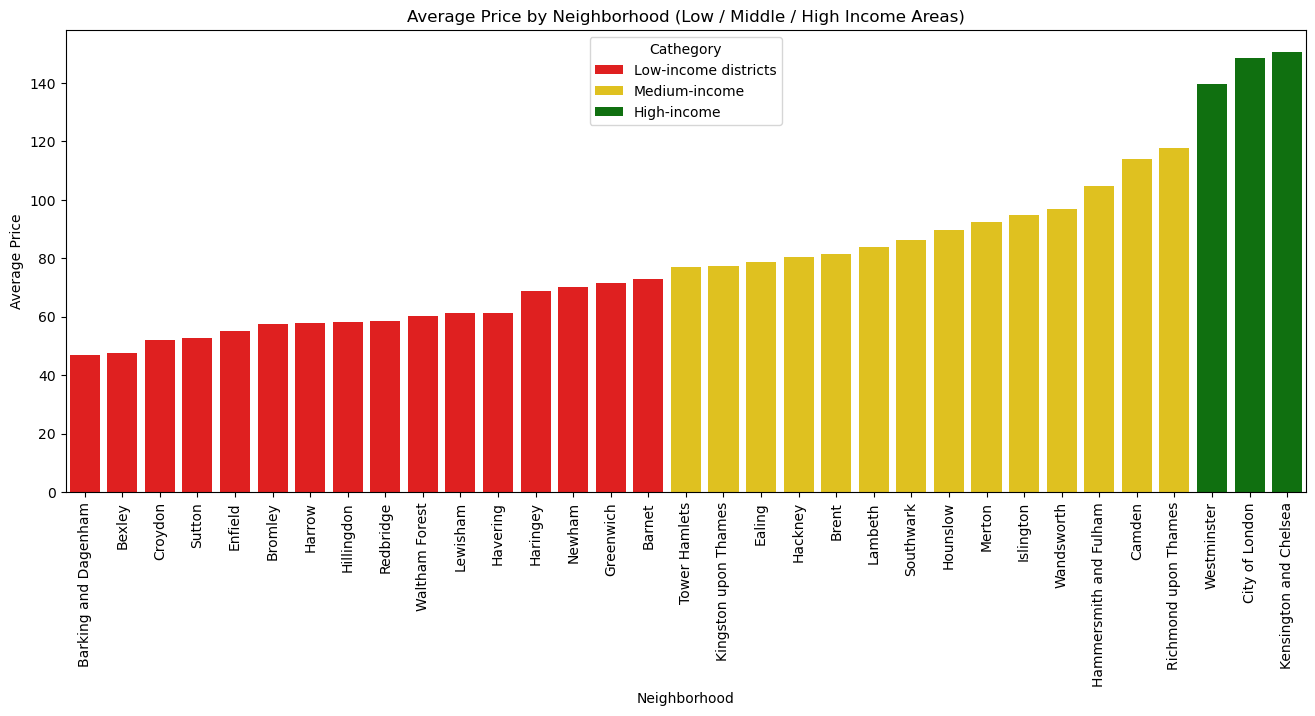

In [ ]:
df_moy = data.groupby('f_neighbourhood_cleansed')['usd_price_day'].mean().reset_index()

kmeans = KMeans(n_clusters=3, random_state=0)
df_moy['f_neighbourhood_cat'] = kmeans.fit_predict(df_moy[['usd_price_day']])

cluster_order = df_moy.groupby('f_neighbourhood_cat')['usd_price_day'].mean().sort_values().index

mapping = {cluster_order[0]: 'Low-income districts',
           cluster_order[1]: 'Medium-income',
           cluster_order[2]: 'High-income'}

df_moy['f_neighbourhood_cat'] = df_moy['f_neighbourhood_cat'].map(mapping)

plt.figure(figsize=(16,6))
sns.barplot(
    data=df_moy.sort_values('usd_price_day'),
    x='f_neighbourhood_cleansed',
    y='usd_price_day',
    hue='f_neighbourhood_cat',
    dodge=False,
    palette={'Low-income districts': 'red', 'Medium-income': 'gold', 'High-income': 'green'}
)
plt.xticks(rotation=90)
plt.title("Average Price by Neighborhood (Low / Middle / High Income Areas)")
plt.xlabel("Neighborhood")
plt.ylabel("Average Price")
plt.legend(title="Cathegory")
plt.show()


In [29]:
mapping = {}
for i,j in zip(df_moy["f_neighbourhood_cleansed"], df_moy["f_neighbourhood_cat"]):
    mapping[i] = j
data["f_neighbourhood_cat"] = data['f_neighbourhood_cleansed'].map(mapping)
data[["f_neighbourhood_cat", 'f_neighbourhood_cleansed']]
data = data.drop(columns='f_neighbourhood_cleansed' )

### **5. Encoding Strategy Development**

**Purpose:**
Determine the optimal method for converting categorical variables into numerical format

**Rationale:**
Choose between one-hot encoding, label encoding, or target encoding based on cardinality and relationship with the target variable

In [ ]:
data = pd.get_dummies(data, drop_first=True)
data = data.astype(int)
print(f'Number of remaining variables: {len(data.columns)}')
data.head()

le nombre de variables est maintenant de : 51


,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_days_since,...,d_wheelchairaccessible,equip_score_lasso,f_property_type_House,f_room_type_Private room,f_room_type_Shared room,f_cancellation_policy_moderate,f_cancellation_policy_strict,f_bed_type_Real Bed,f_neighbourhood_cat_Low-income districts,f_neighbourhood_cat_Medium-income
0,23,1,1,100,1,1,0,8,7,92,...,0,4,0,1,0,0,0,1,0,1
1,50,2,1,91,15,1,0,0,1,671,...,0,30,0,1,0,1,0,0,0,1
2,24,2,1,80,2,1,0,0,1,242,...,0,-20,0,1,0,0,0,1,0,1
3,50,2,1,94,0,1,0,0,2,327,...,0,75,1,1,0,0,0,1,0,1
4,25,1,1,94,0,1,0,0,1,327,...,0,10,1,1,0,0,0,1,0,1


### **6. General Impact Assessment**

**Purpose:**
Evaluate how each dummy variable affects rental prices

**Rationale:**
Determine which amenities/locations have the strongest pricing influence to prioritize feature selection

In [ ]:
f_columns_dummies = data[[col for col in data.columns if col.startswith('f_')]]

for name in ['f_property_type', 'f_room_type', 'f_cancellation_policy', 'f_bed_type','f_neighbourhood_cat']: 
    f_dummies = data[[col for col in data.columns if col.startswith(name)]]


    results = []

    for col in f_dummies.columns:
        mean_0 = data.loc[data[col] == 0, 'usd_price_day'].mean()
        mean_1 = data.loc[data[col] == 1, 'usd_price_day'].mean()
        diff = abs(mean_1 - mean_0)
        corr = data[col].corr(data['usd_price_day'])
        results.append([col, mean_0, mean_1, diff, abs(corr)])

    impact_df = pd.DataFrame(results, columns=['Variable', 'Prix_0', 'Prix_1', 'Différence', 'Corrélation'])
    impact_df = impact_df.sort_values('Difference', ascending=False)

    display(impact_df)


,Variable,Prix_0,Prix_1,Différence,Corrélation
0,f_property_type_House,95.321828,93.637815,1.684013,0.009122


,Variable,Prix_0,Prix_1,Différence,Corrélation
0,f_room_type_Private room,135.298076,49.785849,85.512227,0.527534
1,f_room_type_Shared room,95.476989,38.842593,56.634396,0.071184


,Variable,Prix_0,Prix_1,Différence,Corrélation
1,f_cancellation_policy_strict,80.986631,114.721953,33.735322,0.205175
0,f_cancellation_policy_moderate,96.872436,88.286634,8.585802,0.044749


,Variable,Prix_0,Prix_1,Différence,Corrélation
0,f_bed_type_Real Bed,58.228916,95.605647,37.376731,0.063517


,Variable,Prix_0,Prix_1,Différence,Corrélation
0,f_neighbourhood_cat_Low-income districts,101.525035,63.864156,37.660880,0.177346
1,f_neighbourhood_cat_Medium-income,103.407461,90.330432,13.077029,0.076985


In [32]:
print("columns : ")
for col in f_columns_dummies.columns : 
    corr = data[col].corr(data["usd_price_day"])
    if  abs(corr) < 0.15 : 
        data = data.drop(columns = col)        
    else :
        print(f"{col} : {corr}")

columns : 
f_room_type_Private room : -0.5275341416886701
f_cancellation_policy_strict : 0.2051747690334633
f_neighbourhood_cat_Low-income districts : -0.17734611340914738


<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  4/ Variance Inflation Factor (VIF) Analysis
</div>

**Objective :**

In this section, we conduct a comprehensive multicollinearity analysis using Variance Inflation Factor (VIF) to identify and address highly correlated independent variables in our dataset. Multicollinearity can undermine the stability and interpretability of our regression models, making this a critical step in our data preparation pipeline.


### **1. Analytical Approach**

**Initial VIF Calculation**
- **Purpose:** Compute VIF scores for all quantitative and encoded categorical variables
- **Rationale:** Establish a baseline understanding of multicollinearity levels across all potential predictors

**Threshold-Based Variable Filtering**
- **Purpose:** Identify variables exceeding acceptable VIF thresholds (typically VIF > 5 or VIF > 10)
- **Rationale:** Flag highly correlated variables that may cause model instability and inflated coefficient variances

**Iterative VIF Reduction Process**
- **Purpose:** Systematically remove high-VIF variables and recalculate VIF scores iteratively
- **Rationale:** Progressively eliminate the most problematic variables while monitoring the impact on remaining features

**Correlation Analysis Integration**
- **Purpose:** Cross-reference VIF results with correlation matrices
- **Rationale:** Understand the specific relationships causing multicollinearity and make informed decisions about variable retention

**Business-Centric Variable Selection**
- **Purpose:** Balance statistical requirements with business importance when removing variables
- **Rationale:** Ensure critical business predictors are preserved even if moderately correlated

### **2. Technical Methodology**

**VIF Calculation Principle:**
- VIF measures how much the variance of a regression coefficient is inflated due to multicollinearity
- Formula: $VIF = 1 / (1 - R²)$ where $R²$ is from regressing the variable against all other predictors

**Interpretation:**
- $VIF = 1$: No correlation
- $VIF 1-5$: Moderate correlation
- $VIF 5-10$: High correlation
- $VIF > 10$: Critical multicollinearity

In [33]:
X = data.drop("usd_price_day", axis = 1)

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

colinear_var = []
weak_col = {}
med_col = {}
strong_col = {}
for i,j in zip(vif["Variable"].unique(), vif["VIF"].unique()):
    if j <= 1: 
        weak_col[i] = j
    elif 1 < j <=5: 
        med_col[i] = j
    else : 
        strong_col[i] = j
        colinear_var.append(i)
    

In [34]:
for name, type in zip(["Weak colinearity", "Medium colinearity", "Strong colinearity"], [weak_col, med_col, strong_col]): 
    print(name)
    for i,j in type.items(): 
        print(f"{i} : {j}")
    print('\n')

Weak colinearity
n_days_since : -0.6856209413088363


Medium colinearity
n_number_of_reviews : 3.637866492881304
n_guests_included : 4.304458022725569
n_reviews_per_month : 2.7590589076276077
n_extra_people : 1.5229094918543422
n_minimum_nights : 1.014809163884903
d_24hourcheckin : 1.7942449083214882
d_buzzerwirelessintercom : 1.8036437642427683
d_petsallowed : 1.2371699697810985
f_room_type_Private room : 3.327947855534877
f_cancellation_policy_strict : 1.9290135025550559
f_neighbourhood_cat_Low-income districts : 1.391814007012564


Strong colinearity
n_accommodates : 8.247807282503908
n_bathrooms : 8.814936006613813
n_review_scores_rating : 31.283858974310004
d_airconditioning : 317.7044147033517
d_breakfast : 321.0732658811637
d_cabletv : 185.5336501143866
d_carbonmonoxidedetector : 35.06840819085558
d_dryer : 897.9935018721222
d_elevatorinbuilding : 32.61252559466726
d_essentials : 15.47601684744957
d_familykidfriendly : 3697.040418745918
d_fireextinguisher : 58.06453266445736
d_f

In [ ]:
for col in colinear_var : 
    data = data.drop(columns=col)
data.head()
print("Remaining variables : ")
for col in data.columns : 
    print(col)

nombre de colones restante : 13


<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
">
  MODELISATION
</div>


<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  1/ Feature Scaling & Train-Test Split Strategy
</div>

In [60]:
def calculate_metrics(y_test, y_pred):
    list_metric = {}
    for metric, metric_name in zip([mean_squared_error, mean_absolute_percentage_error, r2_score], ["MSE", "MAPE", "R2"]): 
        list_metric[metric_name] = metric(y_test, y_pred)
    return list_metric

In [37]:
X = data.drop(columns = 'usd_price_day')
y = data["usd_price_day"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [38]:
numerical = [col for col in X.columns if col.startswith('n_')]
X_train_z = X_train.copy()  # Create a copy to keep dummy variables unchanged
X_test_z = X_test.copy()    # Create a copy to keep dummy variables unchanged

#transformation-standardizing scaling
X_train_z[numerical] = X_train[numerical].apply(lambda x: (x - x.mean()) / x.std())
X_test_z[numerical] = X_test[numerical].apply(lambda x: (x - x.mean()) / x.std())

<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  1/ Linear Regression Modeling
</div>


### **Forward Selection Implementation**

**Purpose:**
Iteratively add variables that most improve model performance

**Rationale:**
Build models from simplest to most complex, adding only statistically significant predictors

**Mathematical Procedure:**

1. **Initialize** with no variables:  
   $S_0 = \emptyset$

2. **For** $k = 0, 1, 2, \dots, p-1$:
   - Consider all candidate models by adding one variable $x_j$ where $j \notin S_k$
   - Select the variable that maximizes the improvement criterion:  
     $j^* = \arg\max_{j \notin S_k} F(M_{S_k \cup \{j\}})$
   - If improvement is statistically significant:  
     $S_{k+1} = S_k \cup \{j^*\}$
   - Else terminate

3. **Output** final variable set $S_{final}$

*Where $F$ represents model selection criteria (F-statistic, AIC, BIC, or R² improvement)*

---

### **Backward Elimination Implementation**

**Purpose:**
Iteratively remove least significant variables from full model

**Rationale:**
Start with comprehensive model and eliminate redundant or noisy features

**Mathematical Procedure:**

1. **Initialize** with all variables:  
   $S_0 = \{x_1, x_2, \dots, x_p\}$

2. **For** $k = 0, 1, 2, \dots, p-1$:
   - Consider all models by removing one variable $x_j$ where $j \in S_k$
   - Select the variable with minimal impact on model fit:  
     $j^* = \arg\min_{j \in S_k} \text{p-value}(M_{S_k \setminus \{j\}})$
   - If variable is not statistically significant:  
     $S_{k+1} = S_k \setminus \{j^*\}$
   - Else terminate

3. **Output** final variable set $S_{final}$

In [39]:
# forward selection
def forward_regression(X_train, y_train,  
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):  
    initial_list = []  
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X_train_z.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_z[included+[new_column]]))).fit(disp=False)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True

        if not changed:
            break

    return included


# backward selection
def backward_regression(X_train_z, y_train,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X_train_z.columns)
    while True:
        changed=False
        model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_z[included]))).fit(disp=False)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        if not changed:
            break
    return included


def regression_lineair(X, y):
    X = X.assign()
    model = sm.OLS(y,X)
    result=model.fit()
    return(result)

In [40]:

X_forward = X_train_z[forward_regression(X_train_z, y_train)].assign(Intercept=1)
print(f"Number of selected variables : {len(X_forward.columns)}")
print(regression_lineair(X_forward,y_train).summary())


Number of selected variables : 8
                            OLS Regression Results                            
Dep. Variable:          usd_price_day   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     2403.
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:25:48   Log-Likelihood:            -2.0363e+05
No. Observations:               36152   AIC:                         4.073e+05
Df Residuals:                   36144   BIC:                         4.073e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [41]:
X_backward = X_train_z[backward_regression(X_train_z, y_train)].assign(Intercept=1)
print(f"Number of selected variables : {len(X_backward.columns)}")
print(regression_lineair(X_forward,y_train).summary())

Number of selected variables : 9
                            OLS Regression Results                            
Dep. Variable:          usd_price_day   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     2403.
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:25:48   Log-Likelihood:            -2.0363e+05
No. Observations:               36152   AIC:                         4.073e+05
Df Residuals:                   36144   BIC:                         4.073e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
lr_backward = sm.OLS(y_train, X_backward)
lr_forward = sm.OLS(y_train, X_forward)
    #résultats 
result_B = lr_backward.fit(disp=False)
result_F = lr_forward.fit(disp=False)

# BIC
print(f' BIC backward : {result_B.bic}')
print(f' BIC forward : {result_F.bic}')
if result_B.bic > result_F.bic : 
    col = X_backward.drop("Intercept", axis = 1).columns
    best_reg = sm.OLS(y_test, X_test[col]).fit()
    print('The best model in terms of BIC is : Backward.')
else : 
    col = X_forward.drop("Intercept", axis = 1).columns
    best_reg = sm.OLS(y_test, X_test[col]).fit()
    print('The best model in terms of BIC is : Forward.')


 BIC backward : 407344.2847607734
 BIC forward : 407339.6603270999
Le meilleur modèle en terme de BIC est le modèle : Backward.


In [61]:
y_pred_test_OLS = best_reg.predict(X_test[col])
metric_OLS = pd.Series(calculate_metrics(y_test, y_pred_test_OLS), name="OLS")
metric_OLS.index.name = "metrics"
metric_OLS

metrics
MSE     6129.888882
MAPE       0.547374
R2         0.012125
Name: OLS, dtype: float64

<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  2/ Upgrading OLS Modelization
</div>

While standard Ordinary Least Squares (OLS) regression with stepwise selection (Backward/Forward) provides a solid baseline, it suffers from several limitations that advanced techniques can address:

* Overfitting risk: Stepwise selection can overfit the training data by keeping variables that appear significant by chance
* Coefficient instability: In the presence of multicollinearity, OLS coefficients can become highly unstable and exaggerated
* Limited exploration: Stepwise methods only explore a small subset of possible variable combinations
* No regularization: Standard OLS doesn't penalize complex models, leading to poor generalization

### **1. Lasso Regression**

**Lasso (Least Absolute Shrinkage and Selection Operator)** enhances OLS modeling through L1 regularization:

**Key Advantages:**

- **Automatic Feature Selection**: Performs continuous feature selection by shrinking some coefficients exactly to zero
- **Multicollinearity Handling**: Stabilizes estimates when predictors are correlated by penalizing large coefficients
- **Improved Generalization**: Prevents overfitting through L1 penalty term, enhancing performance on unseen data
- **Enhanced Interpretability**: Produces sparse models with only the most relevant predictors

**Mathematical Formulation:**
$$\min_{\beta} \left\{ \frac{1}{2N} \sum_{i=1}^{N} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}$$

**Workflow Application:**
Serves as both a feature selection tool for complex models and a regularized alternative to standard regression, discovering robust relationships in high-dimensional data.

In [ ]:
# Standardisation des données
scaler = StandardScaler()
X_train_scaled = X_train[col]
X_test_scaled = X_test[col]

# Lasso avec validation croisée
print("=== LASSO REGRESSION ===")
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 0, 50),
    cv=5,
    max_iter=10000,
    random_state=42
)

lasso_cv.fit(X_train_scaled, y_train)

best_alpha_lasso = lasso_cv.alpha_
print(f" Best alpha Lasso: {best_alpha_lasso}")

lasso_coef = pd.DataFrame({
    'variable': col,
    'coefficient': lasso_cv.coef_
})
selected_by_lasso = lasso_coef[lasso_coef['coefficient'] != 0]
print(f"\n Selected variables with Lasso ({len(selected_by_lasso)}/{len(col)}):")
print(selected_by_lasso.sort_values('coefficient', key=abs, ascending=False))


=== LASSO REGRESSION ===
Meilleur alpha Lasso: 0.013257113655901081

Variables sélectionnées par Lasso (8/8):
                                   variable  coefficient
5                  f_room_type_Private room   -74.225067
7  f_neighbourhood_cat_Low-income districts   -23.100399
6              f_cancellation_policy_strict    15.914614
0                         n_guests_included    10.256503
1                       n_reviews_per_month    -4.689431
4                             d_petsallowed     3.030650
2                          n_minimum_nights     0.032390
3                              n_days_since    -0.007478


In [45]:
# Performance Lasso
y_pred_lasso_test = lasso_cv.predict(X_test_scaled)
mse_lasso_test = mean_squared_error(y_test, y_pred_lasso_test)
r2_lasso_test = r2_score(y_test, y_pred_lasso_test)

print(f"\nPerformance Lasso - Test MSE: {mse_lasso_test:.4f}, R²: {r2_lasso_test:.4f}")


Performance Lasso - Test MSE: 4202.3175, R²: 0.3228


### **2. Genetic Algorithm Feature Selection**

#### **What Genetic Algorithms Bring to This Context**
Genetic Algorithms (GAs) provide a global optimization approach for feature selection through evolutionary principles.

**Key Advantages:**

- **Combinatorial Exploration**: Explores diverse variable combinations through mutation and crossover operations, avoiding greedy path limitations
- **Global Optima Search**: Stochastic nature helps escape local optima that trap traditional stepwise methods
- **Multi-Objective Optimization**: Balances model complexity and performance via fitness functions that penalize excessive variables
- **Synergistic Discovery**: Reveals non-intuitive variable interactions through exploration of unconventional combinations

**Evolutionary Process:**
1. **Initialization**: Random population of feature subsets
2. **Selection**: Fittest subsets chosen based on model performance
3. **Crossover**: Combining features from parent subsets
4. **Mutation**: Random feature additions/removals
5. **Iteration**: Repeat until convergence criteria met

**Contextual Role:**
Acts as an intelligent feature selector that complements both stepwise and Lasso approaches, discovering superior variable combinations through evolutionary search rather than statistical heuristics alone.

In [ ]:
class GeneticFeatureSelector(BaseEstimator, RegressorMixin):
    def __init__(self, n_generations=20, population_size=30, 
                 mutation_rate=0.1, n_features=None, random_state=42):
        self.n_generations = n_generations
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.n_features = n_features
        self.random_state = random_state
        
    def _initialize_population(self, n_features):

        np.random.seed(self.random_state)
        if self.n_features:

            population = []
            for _ in range(self.population_size):
                individual = np.zeros(n_features)
                indices = np.random.choice(n_features, self.n_features, replace=False)
                individual[indices] = 1
                population.append(individual)
        else:

            population = np.random.choice([0, 1], size=(self.population_size, n_features))
        return population
    
    def _fitness(self, individual, X, y):

        selected_features = np.where(individual == 1)[0]
        n_selected = len(selected_features)
        
        if n_selected == 0 or n_selected >= X.shape[0]:
            return -np.inf
            
        X_selected = X[:, selected_features]
        

        if np.linalg.matrix_rank(X_selected) < n_selected:
            return -np.inf
            
        try:

            coef = np.linalg.lstsq(X_selected, y, rcond=None)[0]
            y_pred = X_selected @ coef
            
            n_samples = X.shape[0]
            r2 = r2_score(y, y_pred)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_selected - 1)
            
            return adj_r2
        except:
            return -np.inf
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        n_samples, n_features = X.shape
        
        if self.n_features is None:
            self.n_features = min(10, n_features // 2)  # Limite raisonnable
        
        np.random.seed(self.random_state)
        population = self._initialize_population(n_features)
        best_fitness = -np.inf
        best_individual = None
        
        print("Optimisation with  genetic algorithme...")
        for generation in range(self.n_generations):
            fitness_scores = np.array([self._fitness(ind, X, y) for ind in population])
            
            gen_best_idx = np.argmax(fitness_scores)
            if fitness_scores[gen_best_idx] > best_fitness:
                best_fitness = fitness_scores[gen_best_idx]
                best_individual = population[gen_best_idx].copy()
            
            new_population = []
            for _ in range(self.population_size):
                contestants = np.random.choice(self.population_size, 3)
                winner = contestants[np.argmax(fitness_scores[contestants])]
                new_population.append(population[winner].copy())
            
            for i in range(0, self.population_size-1, 2):
                if np.random.random() < 0.8:  # 80% de chance de croisement
                    crossover_point = np.random.randint(1, n_features-1)
                    temp = new_population[i][crossover_point:].copy()
                    new_population[i][crossover_point:] = new_population[i+1][crossover_point:]
                    new_population[i+1][crossover_point:] = temp
            
            for i in range(self.population_size):
                for j in range(n_features):
                    if np.random.random() < self.mutation_rate:
                        new_population[i][j] = 1 - new_population[i][j]
            
            population = new_population
            
            if generation % 5 == 0:
                print(f"Generation {generation}: best fitness = {best_fitness:.4f}")
        
        self.best_individual_ = best_individual
        self.selected_features_ = np.where(best_individual == 1)[0]
        self.best_fitness_ = best_fitness
        
        if len(self.selected_features_) > 0:
            X_selected = X[:, self.selected_features_]
            self.coef_ = np.linalg.lstsq(X_selected, y, rcond=None)[0]
            self.intercept_ = np.mean(y - X_selected @ self.coef_)
        else:
            self.coef_ = np.array([])
            self.intercept_ = np.mean(y)
        
        return self
    
    def predict(self, X):
        X = np.array(X)
        if len(self.selected_features_) == 0:
            return np.full(X.shape[0], self.intercept_)
        
        X_selected = X[:, self.selected_features_]
        return X_selected @ self.coef_ + self.intercept_

print("\n=== GENETIC ALGORITHME ===")
ga_selector = GeneticFeatureSelector(
    n_generations=15,
    population_size=20,
    mutation_rate=0.1,
    n_features=min(8, len(col)),  # Maximum 8 variables
    random_state=42
)


=== ALGORITHME GÉNÉTIQUE ===


In [ ]:
ga_selector.fit(X_train_scaled, y_train)

# Variables sélectionnées par l'AG
selected_by_ga = [col[i] for i in ga_selector.selected_features_]
print(f"\n Selected variables with AG ({len(selected_by_ga)}/{len(col)}):")
print(selected_by_ga)

# Performance AG
y_pred_ga_test = ga_selector.predict(X_test_scaled)
mse_ga_test = mean_squared_error(y_test, y_pred_ga_test)
r2_ga_test = r2_score(y_test, y_pred_ga_test)

print(f"Performance AG - Test MSE: {mse_ga_test:.4f}, R²: {r2_ga_test:.4f}")
print(f"Final fitness (R² ajusted): {ga_selector.best_fitness_:.4f}")

Optimisation par algorithme génétique...
Génération 0: meilleure fitness = 0.0056
Génération 5: meilleure fitness = 0.0057
Génération 10: meilleure fitness = 0.0057

Variables sélectionnées par AG (7/8):
['n_guests_included', 'n_minimum_nights', 'n_days_since', 'd_petsallowed', 'f_room_type_Private room', 'f_cancellation_policy_strict', 'f_neighbourhood_cat_Low-income districts']
Performance AG - Test MSE: 5896.3935, R²: 0.0498
Fitness finale (R² ajusté): 0.0057


### **3. Comparison and result**

In [62]:
y_pred_ols_test = best_reg.predict(X_test[col])
mse_ols_test = mean_squared_error(y_test, y_pred_ols_test)
r2_ols_test = r2_score(y_test, y_pred_ols_test)

comparison = pd.DataFrame({
    'Model': ['OLS (Stepwise)', 'Lasso', 'Genetic Algorithm'],
    'MSE_test': [mse_ols_test, mse_lasso_test, mse_ga_test],
    'R²_test': [r2_ols_test, r2_lasso_test, r2_ga_test],
    'Nb_features': [len(col), len(selected_by_lasso), len(selected_by_ga)],
    'Selected_features': [
        list(col),
        list(selected_by_lasso['variable'].values),
        selected_by_ga
    ]
})

print("\n" + "="*60)
print("DETAILED MODEL COMPARISON")
print("="*60)

for i, row in comparison.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Test MSE: {row['MSE_test']:.4f}")
    print(f"  Test R²: {row['R²_test']:.4f}")
    print(f"  Number of features: {row['Nb_features']}")
    print(f"  Feature list: {row['Selected_features']}")

# Determine the best model
best_model_idx = comparison['MSE_test'].idxmin()
best_model = comparison.loc[best_model_idx, 'Model']
best_mse = comparison.loc[best_model_idx, 'MSE_test']

print(f"\nBEST MODEL: {best_model} (MSE = {best_mse:.4f})")

if best_model != 'OLS (Stepwise)':
    improvement = ((mse_ols_test - best_mse) / mse_ols_test) * 100
    print(f"Improvement of {improvement:.1f}% compared to OLS Stepwise")
    
    if best_model == "Lasso":
        y_pred_test_OLS = y_pred_lasso_test
        metric_OLS = pd.Series(calculate_metrics(y_test, y_pred_test_OLS), name="OLS Regression Lasso")
    elif best_model == "Genetic Algorithm":
        y_pred_test_OLS = y_pred_ga_test
        metric_OLS = pd.Series(calculate_metrics(y_test, y_pred_test_OLS), name="OLS Regression GA")


DETAILED MODEL COMPARISON

OLS (Stepwise):
  Test MSE: 6129.8889
  Test R²: 0.0121
  Number of features: 8
  Feature list: ['n_guests_included', 'n_reviews_per_month', 'n_minimum_nights', 'n_days_since', 'd_petsallowed', 'f_room_type_Private room', 'f_cancellation_policy_strict', 'f_neighbourhood_cat_Low-income districts']

Lasso:
  Test MSE: 4202.3175
  Test R²: 0.3228
  Number of features: 8
  Feature list: ['n_guests_included', 'n_reviews_per_month', 'n_minimum_nights', 'n_days_since', 'd_petsallowed', 'f_room_type_Private room', 'f_cancellation_policy_strict', 'f_neighbourhood_cat_Low-income districts']

Genetic Algorithm:
  Test MSE: 5896.3935
  Test R²: 0.0498
  Number of features: 7
  Feature list: ['n_guests_included', 'n_minimum_nights', 'n_days_since', 'd_petsallowed', 'f_room_type_Private room', 'f_cancellation_policy_strict', 'f_neighbourhood_cat_Low-income districts']

BEST MODEL: Lasso (MSE = 4202.3175)
Improvement of 31.4% compared to OLS Stepwise


<div style="
  background:#bbf7d0;   /* vert pâle */
  color:#000;           /* texte noir */
  font-weight:700;      /* gras mais un peu moins fort que le titre */
  font-size:1.5rem;     /* plus petit qu’un H1 */
  text-align:left;     /* texte à droite */
  padding:12px 16px;
  width:100%;
">
  2/ Ensemble Methods Modelization
</div>

Ensemble methods combine multiple machine learning models to create more robust and accurate predictions than any single model could achieve. Unlike linear models that assume specific functional relationships, ensemble methods can capture complex, non-linear patterns in the data through committee-based approaches. Our methodology employs two powerful ensemble techniques, both benefiting from intelligent feature pre-selection to enhance performance and interpretability.

### **1. Lasso for Feature Selection**

**In this context**, Lasso acts as a **feature quality gatekeeper**, ensuring that our ensemble models focus their learning capacity on the most informative variables rather than wasting resources on noise. This pre-selection step is particularly valuable for tree-based methods, which can otherwise become distracted by irrelevant features during split decisions.

In [ ]:
alphas = 10**np.linspace(10, -2, 100) * 0.5
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_z, y_train)
    coefs.append(lasso.coef_)

lassocv = LassoCV(cv=10, max_iter=100000)
lassocv.fit(X_train_z, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_z, y_train)

selected_features = np.where(lasso.coef_ != 0)[0]

print("better alpha Lasso:", lassocv.alpha_, '\n')

print("selected variable for ensemble methode : ")
for name in lasso.feature_names_in_[:12] :
    print(name) 

better alpha Lasso: 0.25845940006207735 

selected variable for ensemble methode : 
n_number_of_reviews
n_guests_included
n_reviews_per_month
n_extra_people
n_minimum_nights
n_days_since
d_24hourcheckin
d_buzzerwirelessintercom
d_petsallowed
f_room_type_Private room
f_cancellation_policy_strict
f_neighbourhood_cat_Low-income districts


### **2. Random Forest**

Random Forest operates on the **"wisdom of crowds"** principle, building multiple decision trees and aggregating their predictions:

**Mathematical Foundation:**
- **Bootstrap Aggregating**: For $B$ trees, each tree $T_b$ is trained on a bootstrap sample $D_b$ from the original dataset $D$
- **Prediction Aggregation**: 
  - Regression: $\hat{f}_{rf}(x) = \frac{1}{B} \sum_{b=1}^B T_b(x)$
- **Feature Randomization**: At each split, consider only a random subset of $m$ features from $p$ total features

**Key Advantages:**
- **Variance Reduction**: Bagging decreases model variance without increasing bias
- **Built-in Regularization**: Random feature subsets and bootstrap sampling prevent overfitting
- **Feature Importance**: Measured by total decrease in node impurity weighted by probability of reaching that node

**Methodological Role**: Serves as a **stable, reliable benchmark** capturing non-linear relationships and complex interactions with minimal hyperparameter sensitivity.

In [ ]:
X_train_selected = X_train_z.iloc[:, selected_features]
X_test_selected = X_test_z.iloc[:, selected_features]

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_selected, y_train)

best_rf = grid_search.best_estimator_
print("best parameters :", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Meilleurs paramètres : {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


In [63]:
y_pred_rf = best_rf.predict(X_test_selected)

metric_rf = pd.Series(calculate_metrics(y_test, y_pred_rf), name="Random Forest")
metric_rf.index.name = "metrics"
metric_rf

metrics
MSE     3826.230142
MAPE       0.419773
R2         0.383376
Name: Random Forest, dtype: float64


### **3. Gradient Boosting**

Gradient Boosting employs a **"learn from mistakes"** strategy through additive model building:

**Mathematical Foundation:**
- **Additive Expansion**: $F_M(x) = \sum_{m=1}^M \gamma_m h_m(x)$, where $h_m(x)$ are weak learners
- **Gradient Descent Optimization**: At iteration $m$, fit $h_m(x)$ to the negative gradient:
- 
  $$h_m(x) \approx -\left[ \frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)} \right]_{i=1}^n$$

- **Loss Minimization**: $ \gamma_m = \arg\min_\gamma \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)) $

**Key Advantages:**
- **Sequential Refinement**: Each new tree focuses on residuals from previous ensemble
- **Adaptive Learning**: Automatically emphasizes difficult-to-predict instances
- **State-of-the-Art Performance**: Often achieves superior accuracy through systematic error correction

**Pipeline Position**: Represents our **precision instrument** for maximum prediction accuracy, capturing complex data patterns through sequential model building.

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 2, 5]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_selected, y_train)

best_xgb = grid_search.best_estimator_
print("best parameters XGBoost :", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\mabil\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:38:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleurs paramètres XGBoost : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [64]:
y_pred_xgb = best_xgb.predict(X_test_selected)

metric_xgb = pd.Series(calculate_metrics(y_test, y_pred_xgb), name="XGBoost")
metric_xgb.index.name = "metrics"
metric_xgb

metrics
MSE     3969.496338
MAPE       0.430404
R2         0.360288
Name: XGBoost, dtype: float64

<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
"> III - PREVISION AND CONCLUSION</div>

In [65]:
def find_best_model(models_df):
    """
    Find the best model based on multiple metrics from the models dataframe.
    
    Parameters:
    models_df (pd.DataFrame): DataFrame containing model metrics
    
    Returns:
    str: Description of the best model and reasoning
    """
    
    # Extract metrics
    mse_values = models_df.loc['MSE']
    mape_values = models_df.loc['MAPE']
    r2_values = models_df.loc['R2']
    
    # Normalize scores (lower is better for MSE and MAPE, higher is better for R2)
    mse_scores = 1 / mse_values  # Convert to "higher is better"
    mape_scores = 1 / mape_values  # Convert to "higher is better"
    r2_scores = r2_values  # Already "higher is better"
    
    # Normalize all scores to 0-1 range for fair comparison
    mse_normalized = (mse_scores - mse_scores.min()) / (mse_scores.max() - mse_scores.min())
    mape_normalized = (mape_scores - mape_scores.min()) / (mape_scores.max() - mape_scores.min())
    r2_normalized = (r2_scores - r2_scores.min()) / (r2_scores.max() - r2_scores.min())
    
    # Calculate weighted composite score (equal weights for all metrics)
    composite_scores = (mse_normalized + mape_normalized + r2_normalized) / 3
    
    # Find the best model
    best_model = composite_scores.idxmax()
    best_score = composite_scores.max()
    
    # Get the actual metric values for the best model
    best_mse = mse_values[best_model]
    best_mape = mape_values[best_model]
    best_r2 = r2_values[best_model]
    
    # Build reasoning
    reasons = []
    
    # Compare MSE
    if best_mse == mse_values.min():
        reasons.append(f"lowest MSE ({best_mse:.2f})")
    
    # Compare MAPE
    if best_mape == mape_values.min():
        reasons.append(f"lowest MAPE ({best_mape:.3f})")
    
    # Compare R2
    if best_r2 == r2_values.max():
        reasons.append(f"highest R² ({best_r2:.3f})")
    
    # If no single metric is best, mention the balanced performance
    if len(reasons) == 0:
        reasons.append("best overall balanced performance across all metrics")
    
    reason_text = " and ".join(reasons)
    
    return f"The best model is {best_model} because it has the {reason_text}."

In [66]:
def comprehensive_model_analysis(models_df, y_test, predictions_dict):
    """
    Comprehensive model analysis with multiple comparison methods
    """
    # 1. Get best model using your existing function
    best_model_text = find_best_model(models_df)
    print(best_model_text)
    print("\n" + "="*60 + "\n")
    
    # 2. Detailed metrics comparison
    print(" Detailed Metrics Comparison:")
    print(models_df.round(4))
    print("\n")
    
    # 3. Rank models for each metric
    print(" Model Rankings:")
    rankings = pd.DataFrame({
        'MSE Rank': models_df.loc['MSE'].rank(ascending=True),
        'MAPE Rank': models_df.loc['MAPE'].rank(ascending=True),
        'R2 Rank': models_df.loc['R2'].rank(ascending=False)
    })
    rankings['Overall Rank'] = rankings.mean(axis=1).rank()
    print(rankings.round(2))
    print("\n")
    
    return best_model_text

# Enhanced plotting function
def plot_comprehensive_comparison(y_test, predictions_dict, models_df):
    """
    Create comprehensive comparison plots
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution comparison (your existing plot)
    plt.subplot(2, 3, 1)
    for model_name, y_pred in predictions_dict.items():
        sns.kdeplot(y_pred, label=f'{model_name} Pred', alpha=0.7)
    sns.kdeplot(y_test, label='Actual', linewidth=3, color='black', linestyle='--')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title('Prediction Distributions vs Actual')
    plt.legend()
    
    # 2. Actual vs Predicted scatter plots
    plt.subplot(2, 3, 2)
    colors = ['red', 'blue', 'green']
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        plt.scatter(y_test, y_pred, alpha=0.5, label=model_name, color=colors[i], s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    
    # 3. Residual plots
    plt.subplot(2, 3, 3)
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.5, label=model_name, color=colors[i], s=20)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')
    plt.legend()
    
    # 4. Metrics comparison bar chart
    plt.subplot(2, 3, 4)
    metrics_to_plot = ['MSE', 'MAPE', 'R2']
    x_pos = np.arange(len(models_df.columns))
    width = 0.25
    
    for i, metric in enumerate(metrics_to_plot):
        values = models_df.loc[metric].values
        # Normalize for better visualization (except R2)
        if metric != 'R2':
            values = values / values.max()  # Normalize to 0-1
        plt.bar(x_pos + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Normalized Scores')
    plt.title('Model Metrics Comparison')
    plt.xticks(x_pos + width, models_df.columns, rotation=45)
    plt.legend()
    
    # 5. Error distribution
    plt.subplot(2, 3, 5)
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        errors = y_test - y_pred
        sns.kdeplot(errors, label=model_name, fill=True, alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel('Prediction Errors')
    plt.ylabel('Density')
    plt.title('Error Distributions')
    plt.legend()
    
    # 6. Model performance scores
    plt.subplot(2, 3, 6)
    # Calculate composite scores (same as in your function)
    mse_scores = 1 / models_df.loc['MSE']
    mape_scores = 1 / models_df.loc['MAPE']
    r2_scores = models_df.loc['R2']
    
    mse_norm = (mse_scores - mse_scores.min()) / (mse_scores.max() - mse_scores.min())
    mape_norm = (mape_scores - mape_scores.min()) / (mape_scores.max() - mape_scores.min())
    r2_norm = (r2_scores - r2_scores.min()) / (r2_scores.max() - r2_scores.min())
    
    composite_scores = (mse_norm + mape_norm + r2_norm) / 3
    
    plt.bar(range(len(composite_scores)), composite_scores.values, 
            color=['green' if x == composite_scores.max() else 'gray' for x in composite_scores.values])
    plt.xticks(range(len(composite_scores)), composite_scores.index, rotation=45)
    plt.ylabel('Composite Score')
    plt.title('Overall Model Performance')
    
    plt.tight_layout()
    plt.show()

# Additional statistical tests
def statistical_comparison(y_test, predictions_dict):
    """
    Perform statistical comparisons between models
    """
    print("Statistical Comparison:")
    print("-" * 40)
    
    # Calculate RMSE for each model
    rmse_scores = {}
    for model_name, y_pred in predictions_dict.items():
        rmse = np.sqrt(np.mean((y_test - y_pred)**2))
        rmse_scores[model_name] = rmse
        print(f"{model_name}: RMSE = {rmse:.2f}")
    
    # Pairwise comparisons
    print("\n Pairwise RMSE Differences:")
    models = list(predictions_dict.keys())
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            rmse_i = rmse_scores[models[i]]
            rmse_j = rmse_scores[models[j]]
            improvement = ((rmse_j - rmse_i) / rmse_j) * 100
            print(f"{models[i]} vs {models[j]}: {improvement:+.1f}% improvement")

The best model is Random Forest because it has the lowest MSE (3826.23) and lowest MAPE (0.420) and highest R² (0.383).


 Detailed Metrics Comparison:
      Random Forest    XGBoost  OLS Regression Lasso
MSE       3826.2301  3969.4963             4202.3175
MAPE         0.4198     0.4304                0.4895
R2           0.3834     0.3603                0.3228


 Model Rankings:
                      MSE Rank  MAPE Rank  R2 Rank  Overall Rank
Random Forest              1.0        1.0      1.0           1.0
XGBoost                    2.0        2.0      2.0           2.0
OLS Regression Lasso       3.0        3.0      3.0           3.0




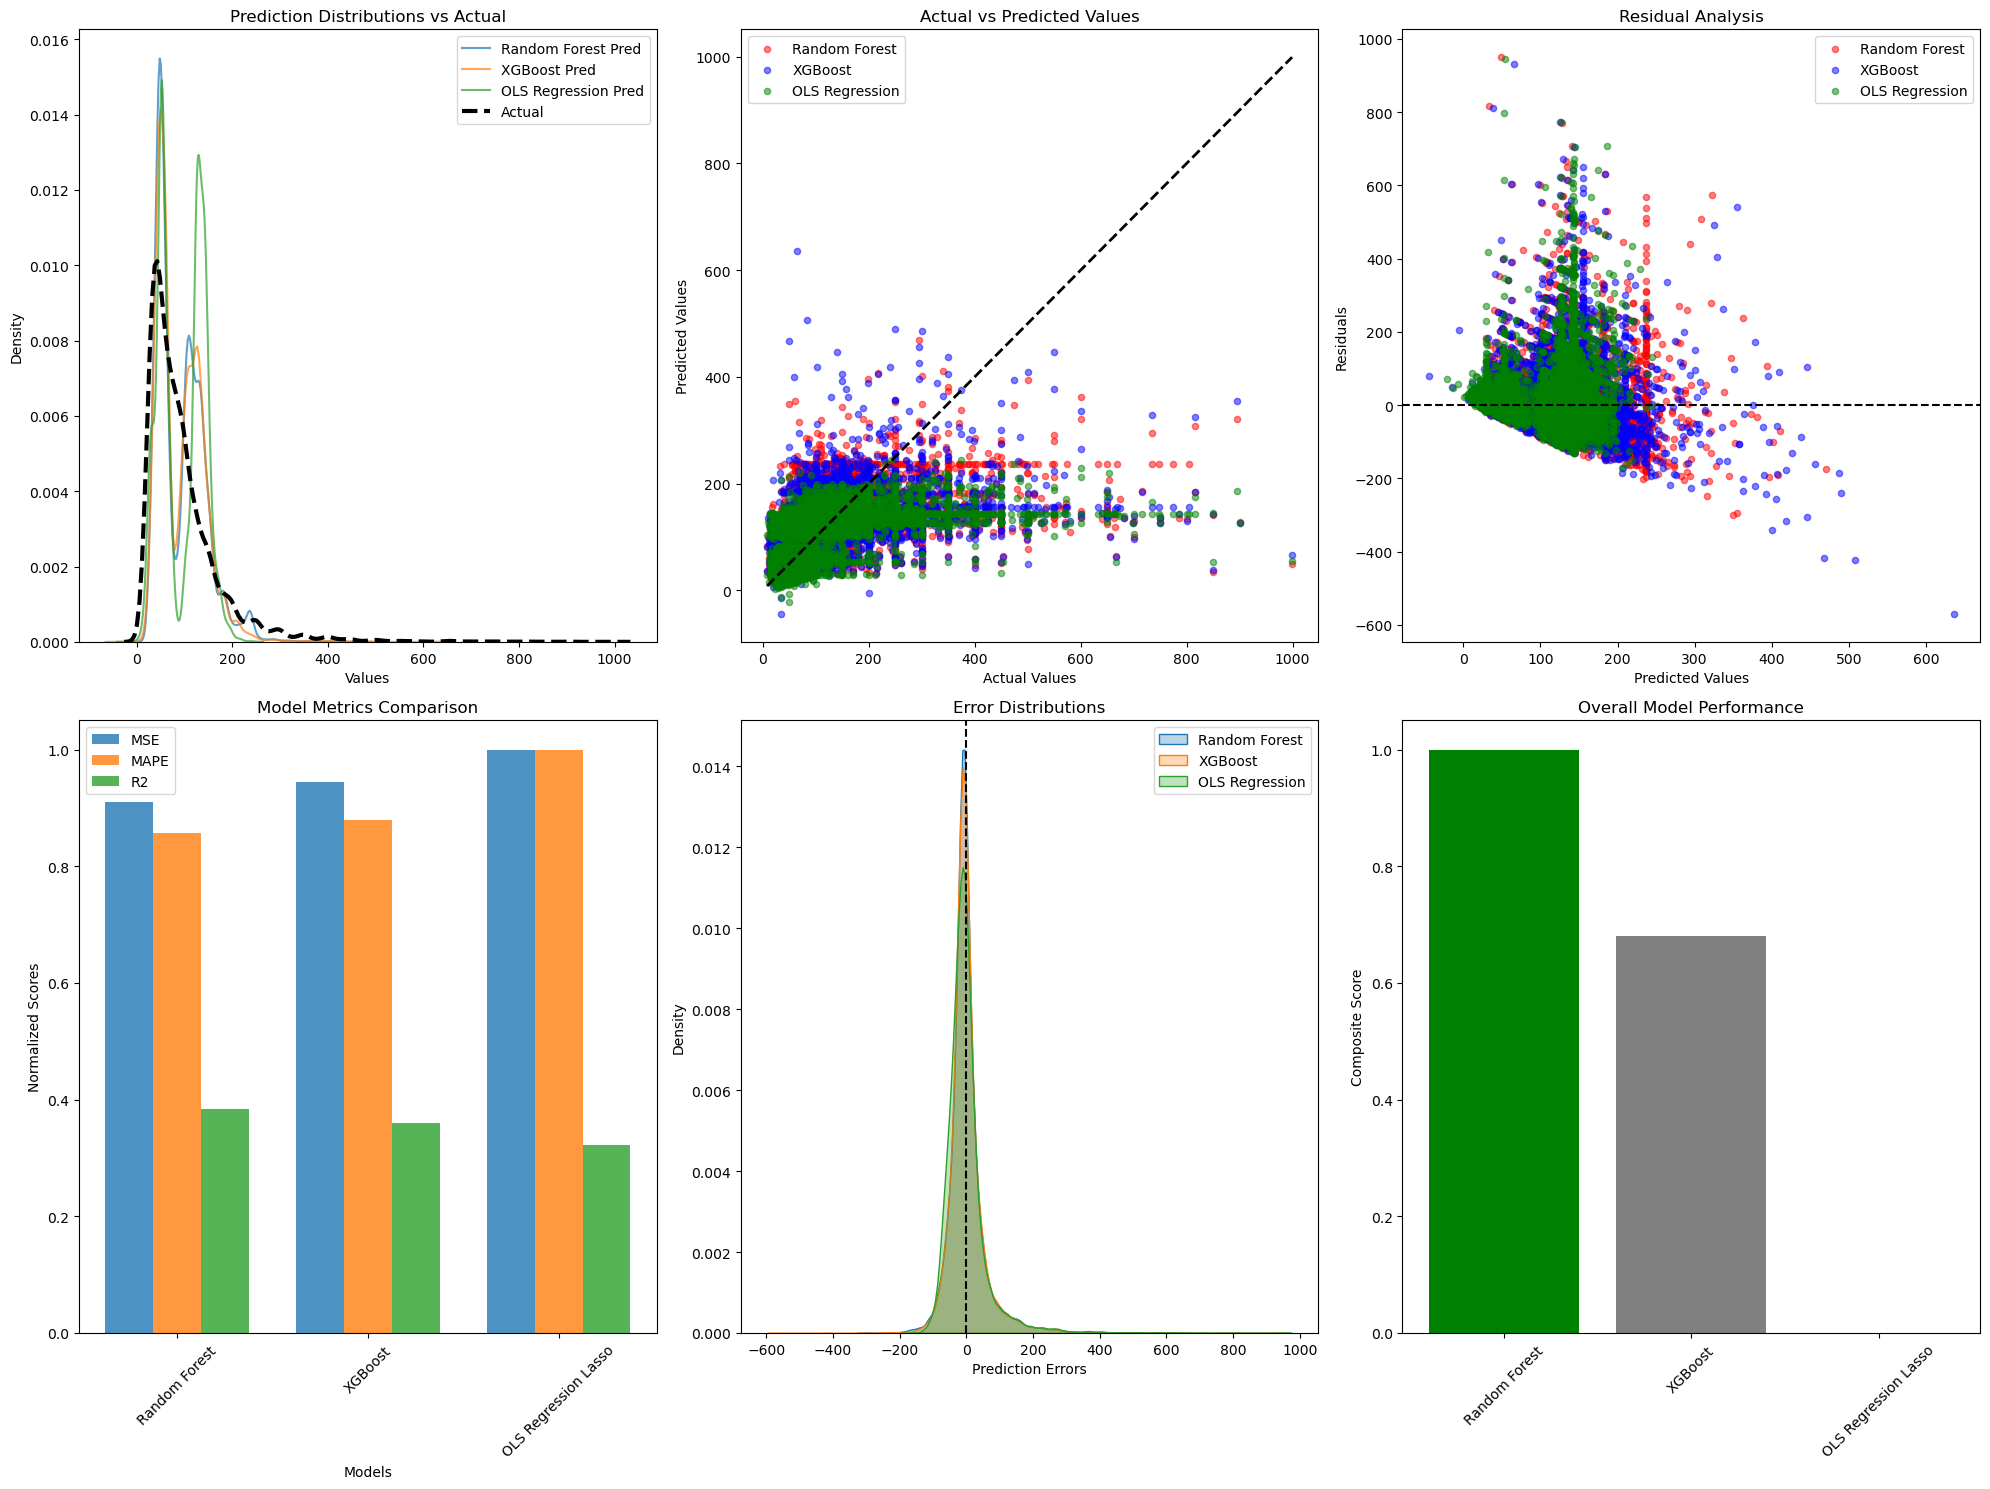

Statistical Comparison:
----------------------------------------
Random Forest: RMSE = 61.86
XGBoost: RMSE = 63.00
OLS Regression: RMSE = 64.83

 Pairwise RMSE Differences:
Random Forest vs XGBoost: +1.8% improvement
Random Forest vs OLS Regression: +4.6% improvement
XGBoost vs OLS Regression: +2.8% improvement


In [67]:


models_df = pd.DataFrame([metric_rf, metric_xgb, metric_OLS]).T
models_df.columns = ['Random Forest', 'XGBoost', 'OLS Regression Lasso']

# Assuming you have these from your models
predictions_dict = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb, 
    'OLS Regression': y_pred_test_OLS
}

# Run comprehensive analysis
best_model = comprehensive_model_analysis(models_df, y_test, predictions_dict)

# Create comprehensive plots
plot_comprehensive_comparison(y_test, predictions_dict, models_df)

# Statistical comparison
statistical_comparison(y_test, predictions_dict)